In [1]:
import os,sys,time,copy
import random
import numpy as np
import pandas as pd
from scipy import interpolate
from scipy.integrate import fixed_quad,quad 
from tqdm import tqdm

from mpmath import fp

#--matplotlib
import matplotlib
from matplotlib.lines import Line2D
matplotlib.rcParams['text.latex.preamble']=r"\usepackage{amsmath}\usepackage{amsfonts}"
matplotlib.rc('text',usetex=True)
import pylab as py
from matplotlib import colors
import matplotlib.gridspec as gridspec

#--torch
import torch
import torch.nn as nn
import torch.optim as optim

print(torch.cuda.is_available())
torch.cuda.empty_cache()
manualSeed = 999 # Set random seed for reproducibility
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
#torch.use_deterministic_algorithms(True) # Needed for reproducible results
#! Number of GPUs available. Use 0 for CPU mode.
ngpu = 1 
#! Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")


False
Random Seed:  999


In [2]:
path = '/Users/barry/work/QuantOm/workspace/tmd/'
sys.path.append(path)

In [3]:
from scipy.special import gamma,zeta,jv,jn_zeros,kv
from scipy.interpolate import griddata,RegularGridInterpolator,CubicSpline

import sidis.qcdlib.params as params
# import sidis.qcdlib.cfg as cfg
from sidis.qcdlib.alphaS  import ALPHAS
# from sidis.qcdlib.alphaS_dev  import ALPHAS as ALPHAS_DEV
from sidis.qcdlib.eweak   import EWEAK
from sidis.qcdlib.mellin import MELLIN
import sidis.qcdlib.special as special
import sidis.qcdlib.config_loader as cfg

from sidis.one_d.qcd_qcf_1d import PDF
from sidis.one_d.qcd_ff_1d import FF_PIP

In [4]:
zeta(2) - np.pi**2/6

np.float64(0.0)

In [5]:
mellin = MELLIN(c=1.9,extended=True)
alphaS = ALPHAS()
pdf = PDF(mellin,alphaS)
ff = FF_PIP(mellin,alphaS)

In [6]:
# pdf.mellin.N.size

In [7]:
X = 10**np.linspace(-4,0,100)
Q2 = 10.0

uv = []
dv = []
g = []
for x in X:
    uv.append(pdf.get_xF(x,Q2,'uv'))
    dv.append(pdf.get_xF(x,Q2,'dv'))
    g.append(pdf.get_xF(x,Q2,'g'))
uv = np.array(uv)
dv = np.array(dv)
g = np.array(g)

In [8]:
# pdf.params

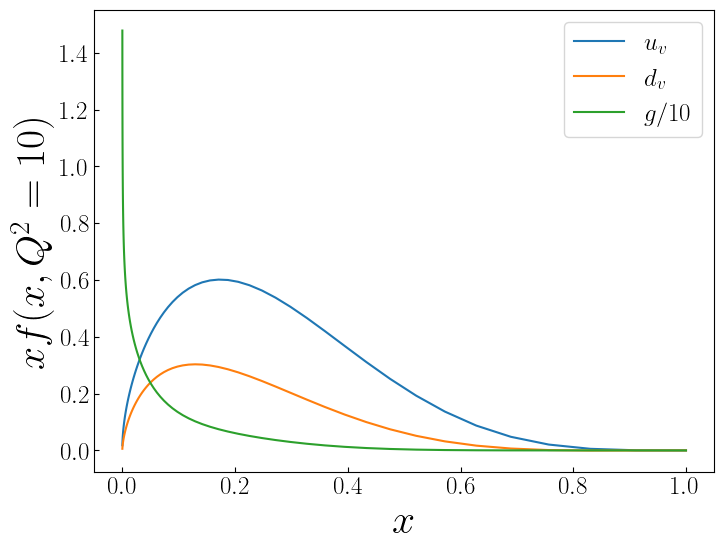

In [9]:
nrows,ncols=1,1
py.figure(figsize=(8*ncols,6*nrows))
ax=py.subplot(nrows,ncols,1)

ax.plot(X,uv,label=r'$u_v$')
ax.plot(X,dv,label=r'$d_v$')
ax.plot(X,g/10,label=r'$g/10$')
ax.legend(fontsize=18)
# ax.semilogx()
ax.set_xlabel(r'$x$',size=30)
ax.set_ylabel(r'$xf(x,Q^2=10)$',size=30)
ax.tick_params(direction='in',labelsize=18,which='both',axis='both')


In [10]:
def get_pdfs(Q2):

    flavs = ['uv','dv','ub','db','s','sb','c','cb','b','bb','g']
    
    X = 10**np.linspace(-4,-1,200)
    X = np.append(X,np.linspace(0.1,1,200))
    
    pdfs = {}
    pdfs['X']=X
    pdfs['Q2']=Q2

    pdfs['XF']={}
    
    for f in flavs:
        pdfs['XF'][f]=np.array([pdf.get_xF(_,Q2,f) for _ in X])

    return pdfs
pdfs = get_pdfs(cfg.Q20)

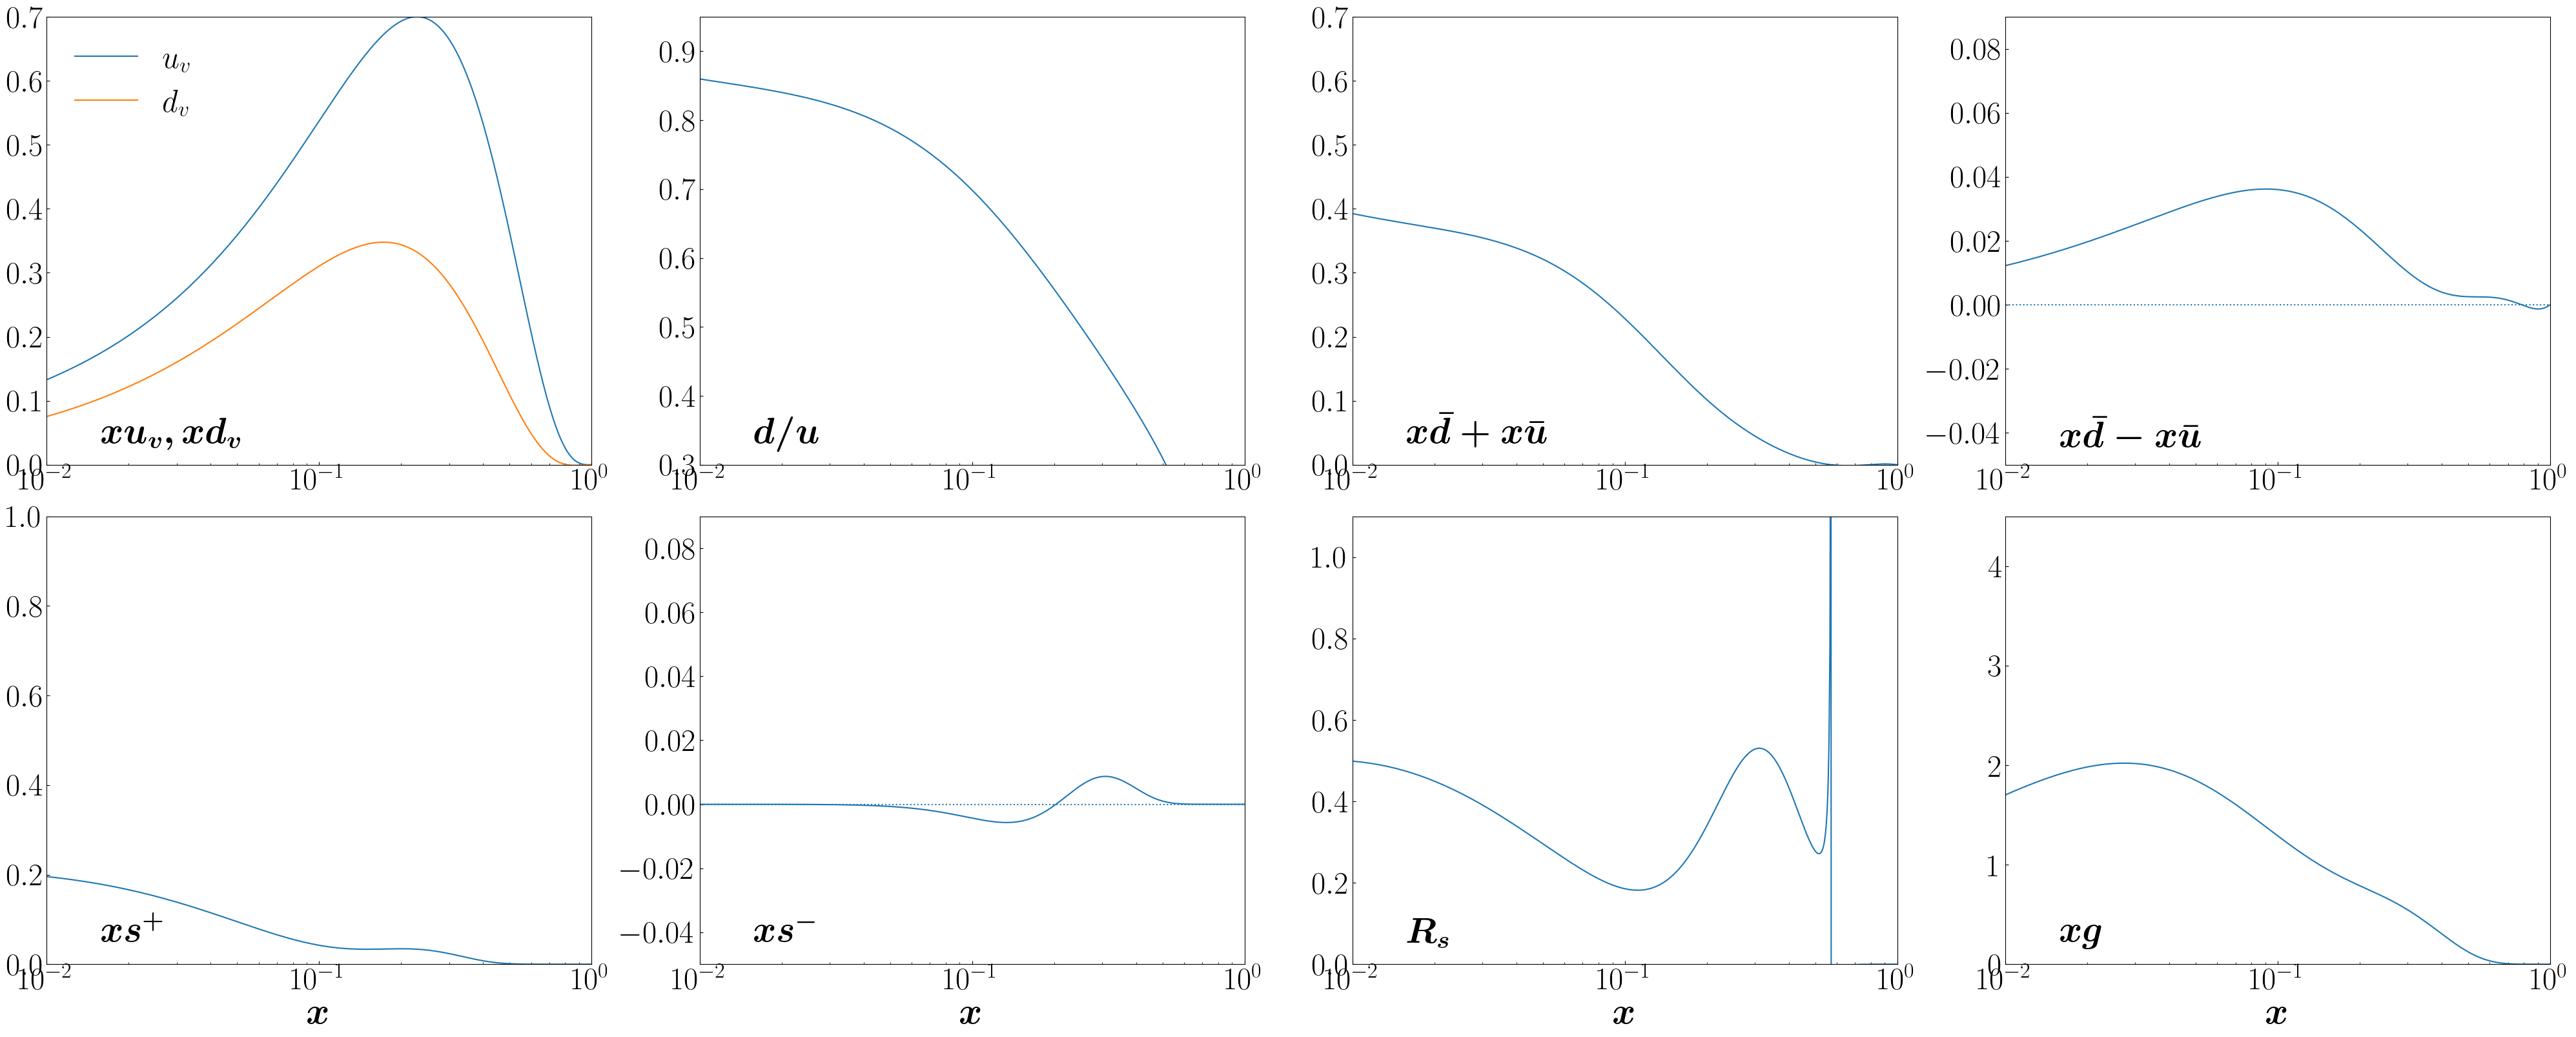

In [11]:
def plot_pdfs(pdfs):
    nrows,ncols=2,4
    py.figure(figsize=(10*ncols,8*nrows))
    cnt=0
    
    X = pdfs['X']
    plot_flavs=['uv,dv','d/u','db+ub','db-ub','sp','sm','Rs','g']
    
    for f in plot_flavs:
        cnt+=1
        ax=py.subplot(nrows,ncols,cnt)
        label = 'test'
        if f=='uv,dv':
            pdf = np.array(pdfs['XF']['uv'])
            ax.plot(X,pdf,label=r'$u_v$')
            
            pdf = np.array(pdfs['XF']['dv'])
            ax.plot(X,pdf,label=r'$d_v$')
            ax.set_ylim(0,0.7)
            ax.legend(fontsize=35,frameon=False,loc='upper left')
            label = 'x u_v, x d_v'

        elif f=='d/u':
            d = np.array(pdfs['XF']['dv']) + np.array(pdfs['XF']['db'])
            u = np.array(pdfs['XF']['uv']) + np.array(pdfs['XF']['ub'])
            donu = np.array(d)/np.array(u)
            ax.plot(X,donu) 
            ax.set_ylim(0.3,0.95)
            label = 'd/u'
            
        elif f=='db+ub':
            pdf = np.array(pdfs['XF']['db']) + np.array(pdfs['XF']['ub'])
            ax.plot(X,pdf)

            ax.set_ylim(0,0.7)
            label = 'x \\bar{d} + x \\bar{u}'
        elif f=='db-ub':
            pdf = np.array(pdfs['XF']['db']) - np.array(pdfs['XF']['ub'])
            ax.plot(X,pdf)
            ax.set_ylim(-0.05,0.09)
            ax.axhline(y=0,ls=':')
            label = 'x \\bar{d} - x \\bar{u}'
        elif f=='sp':
            pdf = np.array(pdfs['XF']['s']) + np.array(pdfs['XF']['sb'])
            ax.plot(X,pdf)
            
            ax.set_ylim(0,1)
            label = 'x s^+'
        elif f=='sm':
            pdf = np.array(pdfs['XF']['s']) - np.array(pdfs['XF']['sb'])
            ax.plot(X,pdf)
            
            ax.set_ylim(-0.05,0.09)
            ax.axhline(y=0,ls=':')
            label = 'x s^-'
        elif f=='Rs':
            num = np.array(pdfs['XF']['s']) + np.array(pdfs['XF']['sb'])
            den = np.array(pdfs['XF']['ub']) + np.array(pdfs['XF']['db'])
            pdf = np.array(num)/np.array(den)
            ax.plot(X,pdf)
            ax.set_ylim(0,1.1)
            label = 'R_s'
        elif f=='g':
            pdf = np.array(pdfs['XF']['g'])
            ax.plot(X,pdf)
            ax.set_ylim(0,4.5)
            label = 'x g'
                
                
        ax.tick_params(direction='in',axis='both',which='both',labelsize=25)
    
        if cnt>4: ax.set_xlabel(r'\boldmath$x$',size=40)
        ax.text(0.1,0.05,r'\boldmath$%s$'%label,transform=ax.transAxes,size=40)
    
        ax.semilogx()
        ax.set_xlim(1e-2,1)
        ax.tick_params(direction='in',labelsize=35,axis='both',which='both')
    py.tight_layout()

plot_pdfs(pdfs)

In [12]:
for k in ff.params:
    print(k,ff.params[k])

g1 [np.float64(6.4479183915853566e-06), np.float64(1.088682720159509), np.float64(5.39543934069994), -0.4545882053452076, -0.12310463103820038]
u1 [np.float64(0.037133548882077594), np.float64(0.5107246235720175), np.float64(5.405612887350822), -0.6471481806543868, -0.5327102329768223]
d1 [np.float64(0.115826210145427), np.float64(-0.4661418824775969), np.float64(9.878756919937004), -2.790284375497949, 1.3745691824429274]
s1 [np.float64(0.2953441679057506), np.float64(-0.6493300183984108), np.float64(4.4479391625899565), -0.4389726815746563, 0.7042631284412002]
c1 [np.float64(0.11300695032419823), np.float64(-0.8896243845942003), np.float64(3.7821163200923746), -1.25116436015642, -1.1300698937418685]
b1 [np.float64(0.11403609145892839), np.float64(-0.2799781981862734), np.float64(5.926483006903505), -2.2738500492053806, 0.0114705372755697]
ub1 [np.float64(0.115826210145427), np.float64(-0.4661418824775969), np.float64(9.878756919937004), -2.790284375497949, 1.3745691824429274]
db1 [np.

In [13]:
def get_ffs(Q2):

    flavs = ['u','d','s','ub','db','sb','c','b','g']
    
    Z = np.linspace(0.025,0.9,200)
    
    ffs = {}
    ffs['Z']=Z
    ffs['Q2']=Q2

    ffs['ZD']={}
    
    for f in flavs:
        ffs['ZD'][f]=np.array([ff.get_xF(_,Q2,f) for _ in Z])

    return ffs
ffs = get_ffs(1000)

In [14]:
ff.get_xF(0.3,1000,'b')

np.float64(0.0)

/var/folders/g4/lx3qy8yd27q_qjssg5ksf0nh0000gr/T/ipykernel_77713/2008539870.py:20: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.semilogy()
/var/folders/g4/lx3qy8yd27q_qjssg5ksf0nh0000gr/T/ipykernel_77713/2008539870.py:21: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_xlim(0.025,0.9)


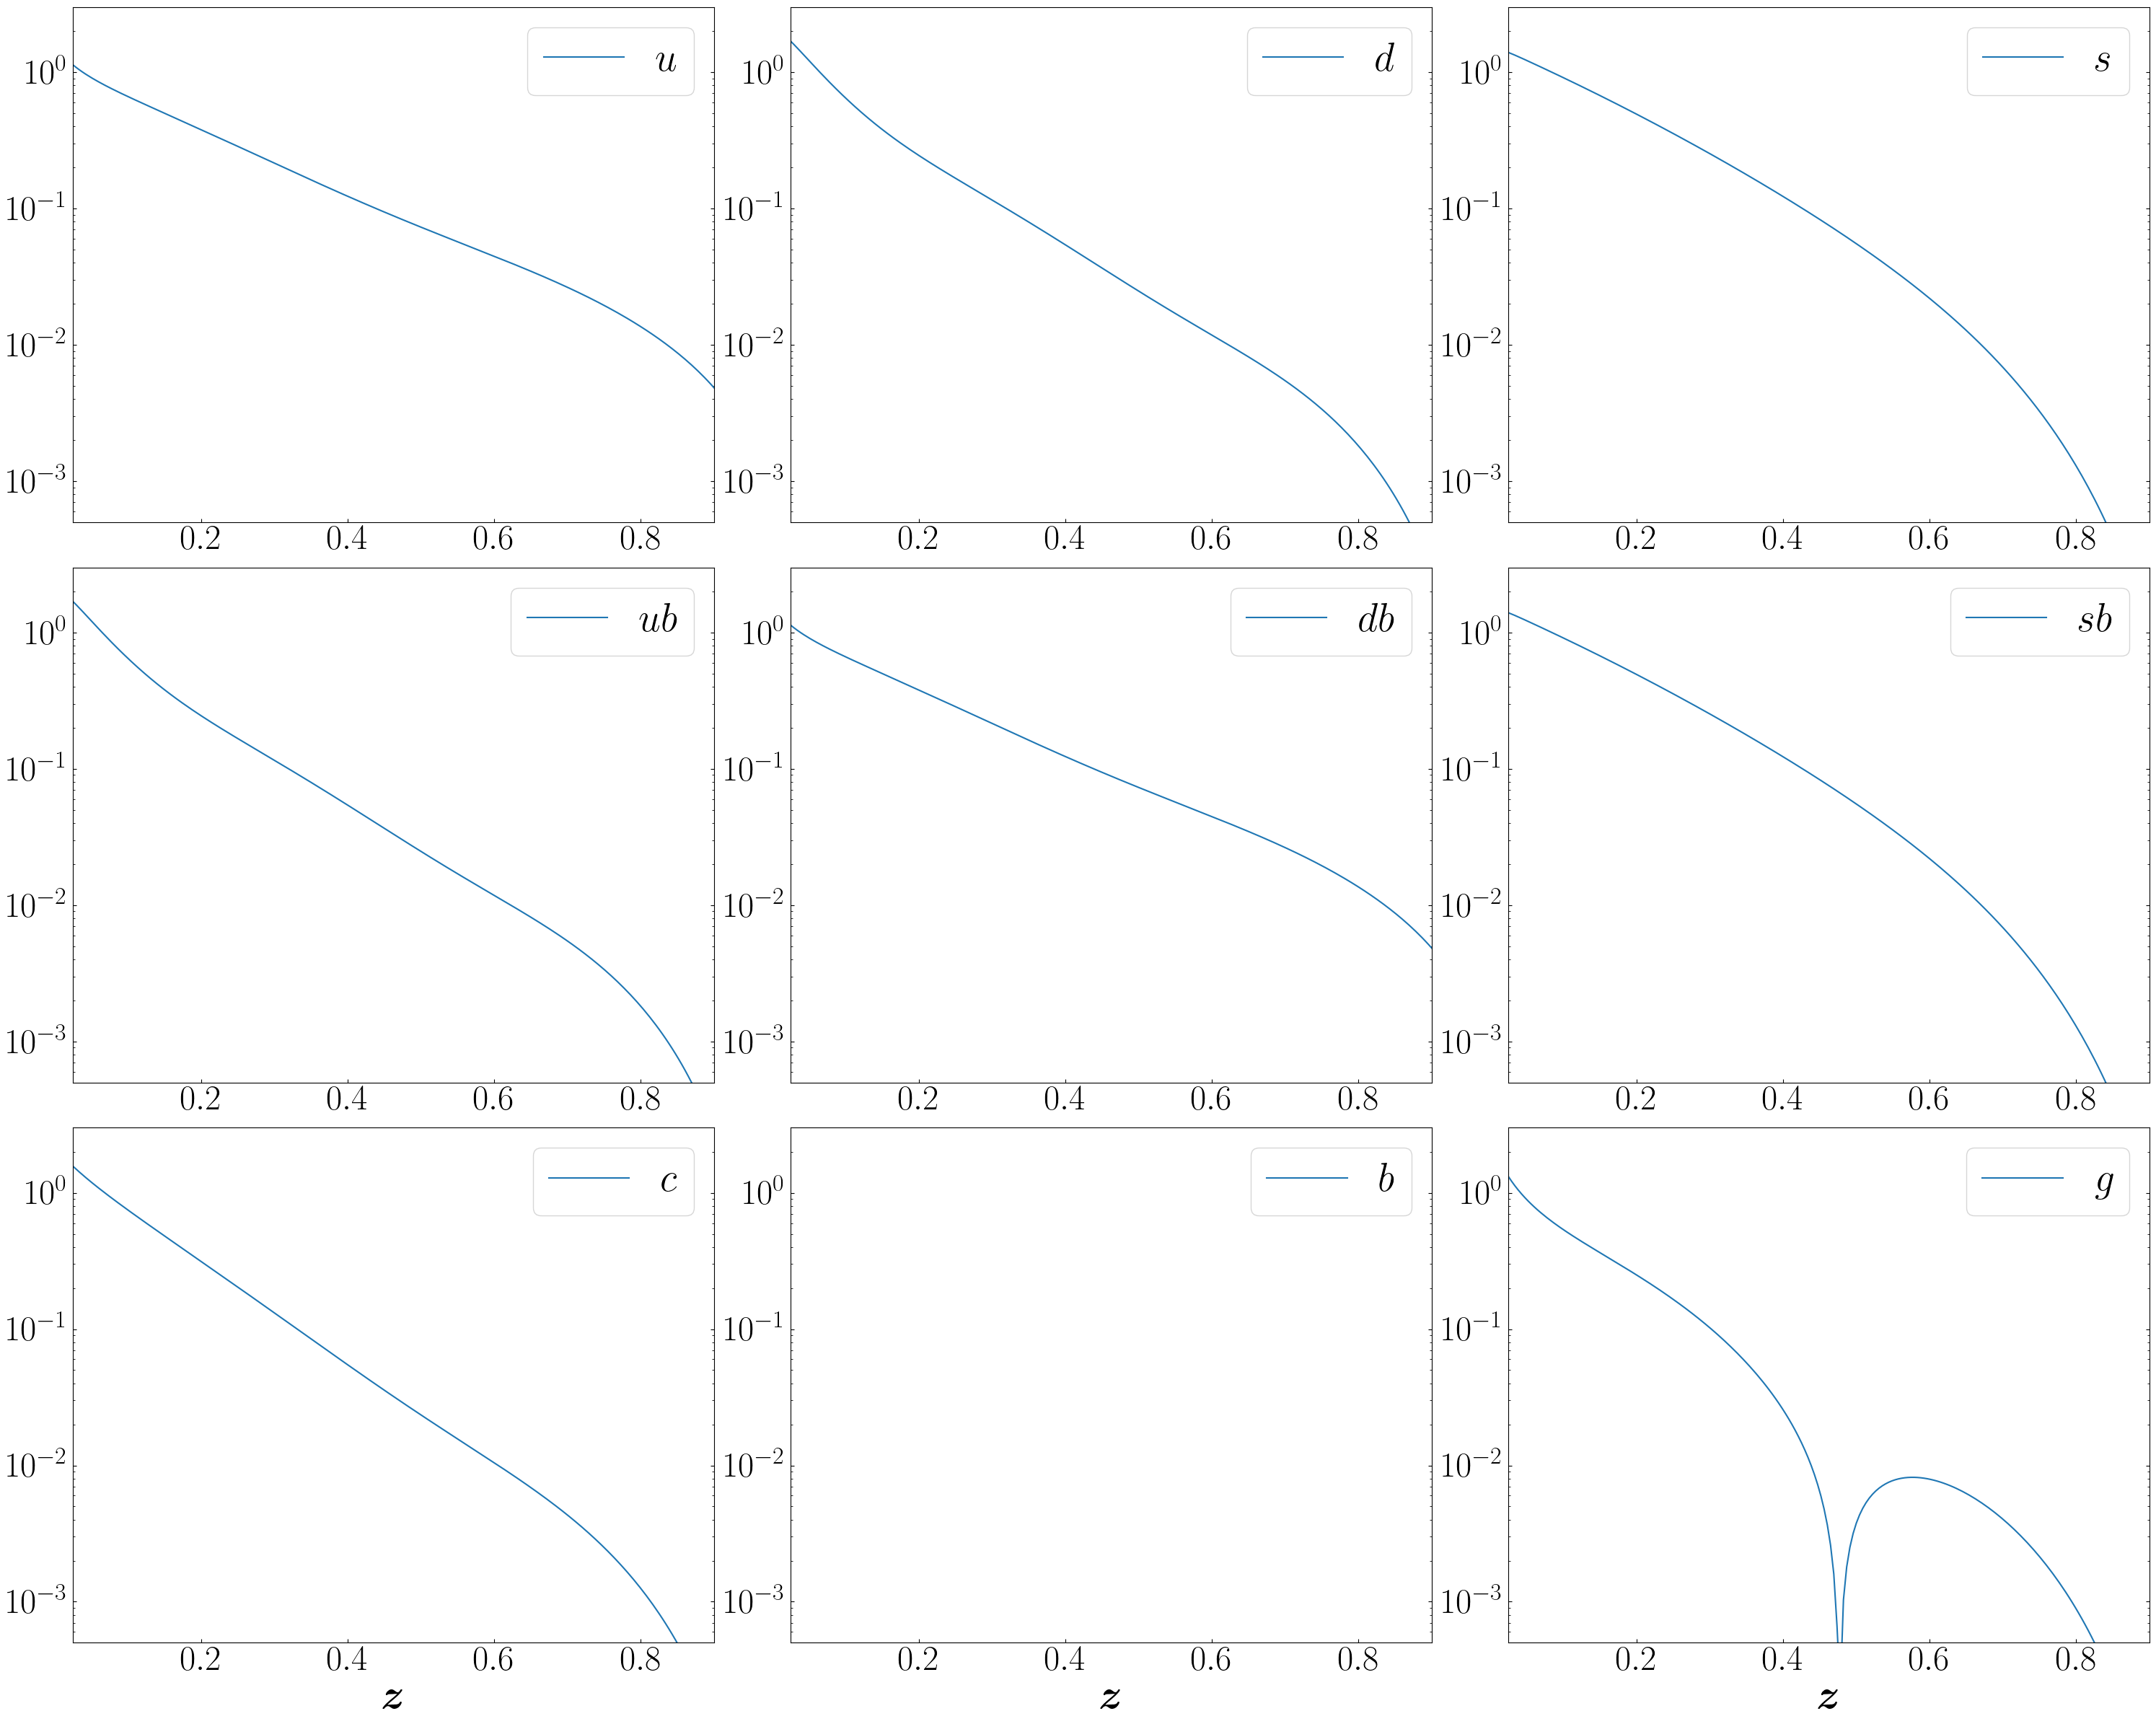

In [15]:
def plot_ffs(ffs):
    nrows,ncols=3,3
    py.figure(figsize=(10*ncols,8*nrows))
    cnt=0
    
    Z = ffs['Z']
    plot_flavs=ffs['ZD'].keys()
    
    for f in plot_flavs:
        cnt+=1
        ax=py.subplot(nrows,ncols,cnt)
        ax.plot(Z,np.abs(ffs['ZD'][f]),label=r'$%s$'%f)
                
        ax.tick_params(direction='in',axis='both',which='both',labelsize=25)

        ax.legend(fontsize=40)
        if cnt>6: ax.set_xlabel(r'\boldmath$z$',size=40)
        # if f=='b': print(ffs['ZD'][f])
    
        ax.semilogy()
        ax.set_xlim(0.025,0.9)
        ax.set_ylim(5e-4,3)
        ax.tick_params(direction='in',labelsize=35,axis='both',which='both',right=True)
    py.tight_layout()
    
plot_ffs(ffs)

In [16]:
# ffs['ZD']['c']

In [17]:
class MODEL:
    
    def __init__(self):
        #--params
        euler=special.euler

        self.Q0 = np.sqrt(cfg.Q20)
        self.C1=2*np.exp(-euler)
        self.C2=1
        
        self.bmax = self.C1/self.Q0 #--so that mub > mu_0
    
    #============================================================
    #--Defining functions associated with bstar
    #============================================================
    #--typical logarithm in perturbative expansions
    def get_Log(self,bT,mu):  
        """
        Typical log in the expansion
        """
        return np.log(mu*bT/self.C1)

    #--Setting up b_*
    def get_bstar(self,bT):
        """
        Returns b*
        """
        return bT/np.sqrt(1+bT**2/self.bmax**2)

    def get_mub(self,bT): 
        """
        Returns mub* 
        """
        return self.C1/self.get_bstar(bT)


In [18]:
tmdmodel = MODEL()

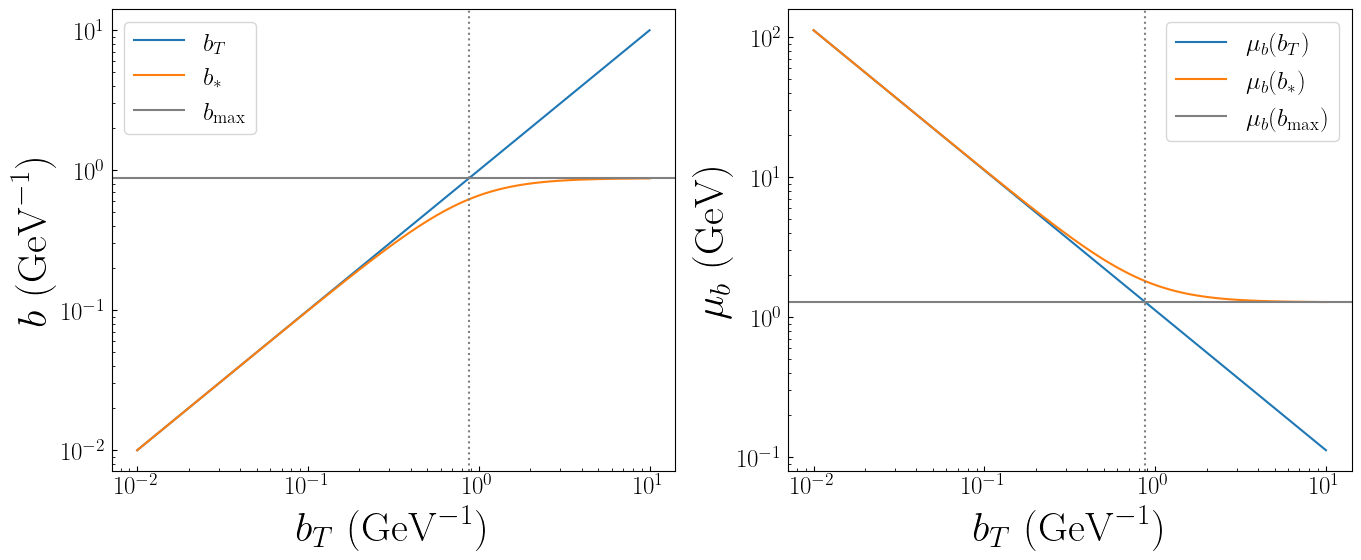

In [19]:
nrows,ncols = 1,2
py.figure(figsize=(8*ncols,6*nrows))

bT = 10**np.linspace(-2,1,100)

bstar = tmdmodel.get_bstar(bT)

mubstar = tmdmodel.get_mub(bT)
mu_nobstar = tmdmodel.C1 / bT

ax=py.subplot(nrows,ncols,1)
ax.plot(bT,bT,label=r'$b_T$')
ax.plot(bT,bstar,label=r'$b_*$')
ax.axvline(x=tmdmodel.bmax,ls=':',c='grey')
ax.axhline(y=tmdmodel.bmax,c='grey',label=r'$b_{\rm max}$')
ax.tick_params(direction='in',labelsize=18,axis='both',which='both')
# ax.set_xlim(0,2)
# ax.set_ylim(0,2)
ax.set_ylabel(r'$b~({\rm GeV}^{-1})$',size=30)
ax.loglog()
ax.legend(fontsize=18)
ax.set_xlabel(r'$b_T~({\rm GeV}^{-1})$',size=30)

ax=py.subplot(nrows,ncols,2)
ax.plot(bT,mu_nobstar,label=r'$\mu_b(b_T)$')
ax.plot(bT,mubstar,label=r'$\mu_b(b_*)$')
ax.axvline(x=tmdmodel.bmax,ls=':',c='grey')
ax.axhline(y= tmdmodel.C1 / tmdmodel.bmax,ls='-',c='grey',label=r'$\mu_b(b_{\rm max})$')
ax.tick_params(direction='in',labelsize=18,axis='both',which='both')
ax.semilogx()
ax.semilogy()
ax.set_xlabel(r'$b_T~({\rm GeV}^{-1})$',size=30)
ax.set_ylabel(r'$\mu_b~({\rm GeV})$',size=30)
ax.legend(fontsize=18)


In [20]:
class PDF_OPE:
    
    def __init__(self,pdf):

        self.iorder = cfg.tmd_order #--LO: 0, NLO: 1
        
        self.pdf = pdf
        self.mellin = pdf.mellin
        
        self.tmdmodel=tmdmodel
        self.alphaS=alphaS
        
        self.CF=params.CF
        self.CA=params.CA
        self.TR=params.TR
        self.TF=params.TF
        
        #--set_charges
        quarkcharges = np.zeros(11)
        quarkcharges[0] = 0 # gluon
        quarkcharges[1] = 2/3 # u
        quarkcharges[2] =-1/3 # d
        quarkcharges[3] =-1/3 # s
        quarkcharges[4] = 2/3 # c
        quarkcharges[5] =-1/3 # b

        quarkcharges[-1] =-2/3 # baru
        quarkcharges[-2] = 1/3 # bard
        quarkcharges[-3] = 1/3 # bars
        quarkcharges[-4] =-2/3 # barc
        quarkcharges[-5] = 1/3 # barb
        self.quarkcharges=quarkcharges
        #============================================================
        #--Storages
        #============================================================

        self.storage_ope={}
        self.fmap={1:'u',2:'d',3:'s',4:'c',5:'b',-5:'bb',-4:'cb',-3:'sb',-2:'db',-1:'ub',0:'g'}
        
        self.setup()

    def reset_storage_ope(self):
        self.storage_ope={}

    #--this function is in special.get_psi(i,N)
    #def get_psi(self,i,N):
    #    return fp.psi(i,complex(N.real,N.imag))

    def setup(self):
        #============================================================
        #--Setting up OPE
        #============================================================
        N=self.mellin.N
        self.N=N
        
        psi0N = special.get_psi(0,N)
        
        self.NLOq1= -1/N - 1/(N+1) - 2*special.euler - 2*psi0N # M transform of Pqq=(2/(1-x)_{+} -1-x)
        self.NLOq2=  1/N - 1/(N+1) # M transform of (1-x)

        self.NLOg1= 1/N - 2/(N+1) + 2/(N+2)  # M transform of Pgq=1-2x(1-x)
        self.NLOg2= 1/(N+1)-1/(N+2)  # M tranform of x(1-x) 

        
    def get_OPE_TMDPDF(self,x,bT):
        """
        Returns an 11-dimensional array of flavors for the OPE for a given x and bT
        x: float
        bT: float
        """
        
        mub   = self.tmdmodel.get_mub(bT) # returns mub*
        zeta = mub**2
        bstar = self.tmdmodel.get_bstar(bT) # returns b*
        
        key=(x,bT,zeta)

        if key in self.storage_ope:
            if float(mub**2) not in self.pdf.storage:
                self.reset_storage_ope()
        
        if key not in self.storage_ope:
            
            N=self.mellin.N           

            aS=self.alphaS.get_a(mub**2) #- alphaS/(4 pi)
            
            Log=self.tmdmodel.get_Log(bstar,mub)

            self.pdf.evolve(mub**2)
            
            moments=self.pdf.storage[mub**2]

            Cq=np.ones(N.size,dtype=np.complex128)
            Cg=np.zeros(N.size,dtype=np.complex128)

            if self.iorder>=1:
                Cq+=aS*self.CF*(-4*Log**2-4*Log*np.log(zeta/mub**2)-4*Log*self.NLOq1+2*self.NLOq2-np.pi**2/6) 
                Cg+=aS*self.TF*(-4*Log*self.NLOg1+4*self.NLOg2) 

            mellin_convolutions=np.zeros((11,N.size),dtype=np.complex128)
            for i in [1,2,3,4,5]:
                mellin_convolutions[+i]=Cq*moments[self.fmap[+i]] + Cg*moments['g']
                mellin_convolutions[-i]=Cq*moments[self.fmap[-i]] + Cg*moments['g']

            xspace_convolutions=np.zeros(11)
            for i in [1,2,3,4,5]:
                xspace_convolutions[+i]=self.mellin.invert(x,mellin_convolutions[+i])
                xspace_convolutions[-i]=self.mellin.invert(x,mellin_convolutions[-i])
            self.storage_ope[key]=xspace_convolutions

        return self.storage_ope[key]


In [21]:
ff.evolve(1000)

In [22]:
# ff.storage[1000]['bp']

In [23]:
class FF_OPE:
    
    def __init__(self,ff,iorder=None):

        if iorder == None: self.iorder = cfg.tmd_order #--LO: 0, NLO: 1
        else: self.iorder = iorder
        print('iorder: ', self.iorder)
        
        self.ff = ff
        self.mellin = ff.mellin
        
        self.tmdmodel=tmdmodel
        self.alphaS=alphaS
        
        self.CF=params.CF
        self.CA=params.CA
        self.TR=params.TR
        self.TF=params.TF
        
        #--set_charges
        quarkcharges = np.zeros(11)
        quarkcharges[0] = 0 # gluon
        quarkcharges[1] = 2/3 # u
        quarkcharges[2] =-1/3 # d
        quarkcharges[3] =-1/3 # s
        quarkcharges[4] = 2/3 # c
        quarkcharges[5] =-1/3 # b

        quarkcharges[-1] =-2/3 # baru
        quarkcharges[-2] = 1/3 # bard
        quarkcharges[-3] = 1/3 # bars
        quarkcharges[-4] =-2/3 # barc
        quarkcharges[-5] = 1/3 # barb
        self.quarkcharges=quarkcharges
        #============================================================
        #--Storages
        #============================================================

        self.storage_ope={}
        self.fmap={1:'u',2:'d',3:'s',4:'c',5:'b',-5:'bb',-4:'cb',-3:'sb',-2:'db',-1:'ub',0:'g'}
        
        self.setup()

    def reset_storage_ope(self):
        self.storage_ope={}

    #--this function is in special.get_psi(i,N)
    #def get_psi(self,i,N):
    #    return fp.psi(i,complex(N.real,N.imag))

    def setup(self):
        #============================================================
        #--Setting up OPE
        #============================================================
        N=self.mellin.N
        self.N=N
        
        S2Nm1 = zeta(2) - special.get_psi(1,N-1 +1)
        S2Np1 = zeta(2) - special.get_psi(1,N+1 +1)


        """
        quark pieces: Mellin transform of [z^2 \mathbb{C}_{q \to q}(z)] according to 1604.07869:
        CF * (2 * (1-z) + 4 * (1+z**2) * log(z) / (1-z) - delta(1-z) * pi**2/6); we take the CF factor out and multiply later as well as the pi**2/6 term
        """
        self.NLOq = 4 * (S2Nm1 - zeta(2) + S2Np1 - zeta(2)) + 2 / N - 2 / (N + 1)

        """
        gluon pieces: Mellin transform of [z^2 \mathbb{C}_{q \to g}(z)] according to 1604.07869:
        CF * (2 * z + 4 * (1 + (1-z)**2)/z * log(z)); we take the CF factor out and multiply later
        """
        self.NLOg = 2 / (N + 1) - 8 / (N - 1)**2 + 8 / N**2 - 4 / (N + 1)**2


    def get_OPE_TMDFF(self,z,bT):
        """
        Returns an 11-dimensional array of flavors for the OPE for a given x and bT
        z: float
        bT: float
        """
        
        mub   = self.tmdmodel.get_mub(bT) # returns mub*
        zeta = mub**2
        bstar = self.tmdmodel.get_bstar(bT) # returns b*
        
        key=(z,bT,zeta)

        if key in self.storage_ope:
            if float(mub**2) not in self.ff.storage:
                self.reset_storage_ope()
        
        if key not in self.storage_ope:
            
            N=self.mellin.N           

            aS=self.alphaS.get_a(mub**2) #- alphaS/(4 pi)
            
            Log=self.tmdmodel.get_Log(bstar,mub)

            self.ff.evolve(mub**2)
            
            moments=self.ff.storage[mub**2]

            Cq=np.ones(N.size,dtype=np.complex128)
            Cg=np.zeros(N.size,dtype=np.complex128)

            if self.iorder>=1:

                Cq+=aS*self.CF*(self.NLOq - np.pi**2 / 6)
                Cg+=aS*self.CF*(self.NLOg)

            mellin_convolutions=np.zeros((11,N.size),dtype=np.complex128)
            for i in [1,2,3,4,5]:
                mellin_convolutions[+i] = Cq*moments[self.fmap[+i]] + Cg*moments['g']
                mellin_convolutions[-i] = Cq*moments[self.fmap[-i]] + Cg*moments['g']

            zspace_convolutions=np.zeros(11)
            for i in [1,2,3,4,5]:
                zspace_convolutions[+i] = 1 / z**2 * self.mellin.invert(z,mellin_convolutions[+i])
                zspace_convolutions[-i] = 1 / z**2 * self.mellin.invert(z,mellin_convolutions[-i])
                
            self.storage_ope[key]=zspace_convolutions

        return self.storage_ope[key]

    def get_OPE_TMDFF_zspace(self,z,bT):
        """
        Returns an 11-dimensional array of flavors for the OPE for a given x and bT
        z: float
        bT: float
        """
        
        mub   = self.tmdmodel.get_mub(bT) # returns mub*
        zeta = mub**2
        bstar = self.tmdmodel.get_bstar(bT) # returns b*
        
        
        aS=self.alphaS.get_a(mub**2) #- alphaS/(4 pi)
        
        Log=self.tmdmodel.get_Log(bstar,mub)

        self.ff.evolve(mub**2)
        
        moments=self.ff.storage[mub**2]

        OPE_zspace = np.zeros(11)
        for i in [1,2,3,4]:
            OPE_zspace[+i] = 1 / z**2 * self.mellin.invert(z,moments[self.fmap[+i]])
            OPE_zspace[-i] = 1 / z**2 * self.mellin.invert(z,moments[self.fmap[-i]])

        if self.iorder>=1:
            quark_piece_integrand = lambda xi,flav: 1 / xi * (2 * (1 - z/xi) + 4 * (1 + z**2/xi**2)/(1 - z/xi) * np.log(z/xi)) * self.mellin.invert(xi,moments[flav])
            gluon_piece_integrand = lambda xi: 1 / xi * ( 2 * z/xi + 4 * (1 + (1-z/xi)**2) / (z/xi)* np.log(z/xi)) * self.mellin.invert(xi,moments['g'])
            gluon_piece = aS * self.CF / z**2 * quad(gluon_piece_integrand, z, 1)[0]
            for i in [1,2,3,4]:
                OPE_zspace[+i] += aS*self.CF/z**2 * (quad(quark_piece_integrand, z, 1, args=(self.fmap[+i]))[0] - np.pi**2/6 * self.mellin.invert(z,moments[self.fmap[+i]])) + gluon_piece
                OPE_zspace[-i] += aS*self.CF/z**2 * (quad(quark_piece_integrand, z, 1, args=(self.fmap[-i]))[0] - np.pi**2/6 * self.mellin.invert(z,moments[self.fmap[-i]])) + gluon_piece

        return OPE_zspace



In [24]:
print(quad(lambda x: x**(14-1) * np.log(x) / (x - 1), 0,1)[0])
print(special.get_psi(1,[14]))

0.07404026866401035
[0.07404027+0.j]


In [25]:
# special.gamma(2)

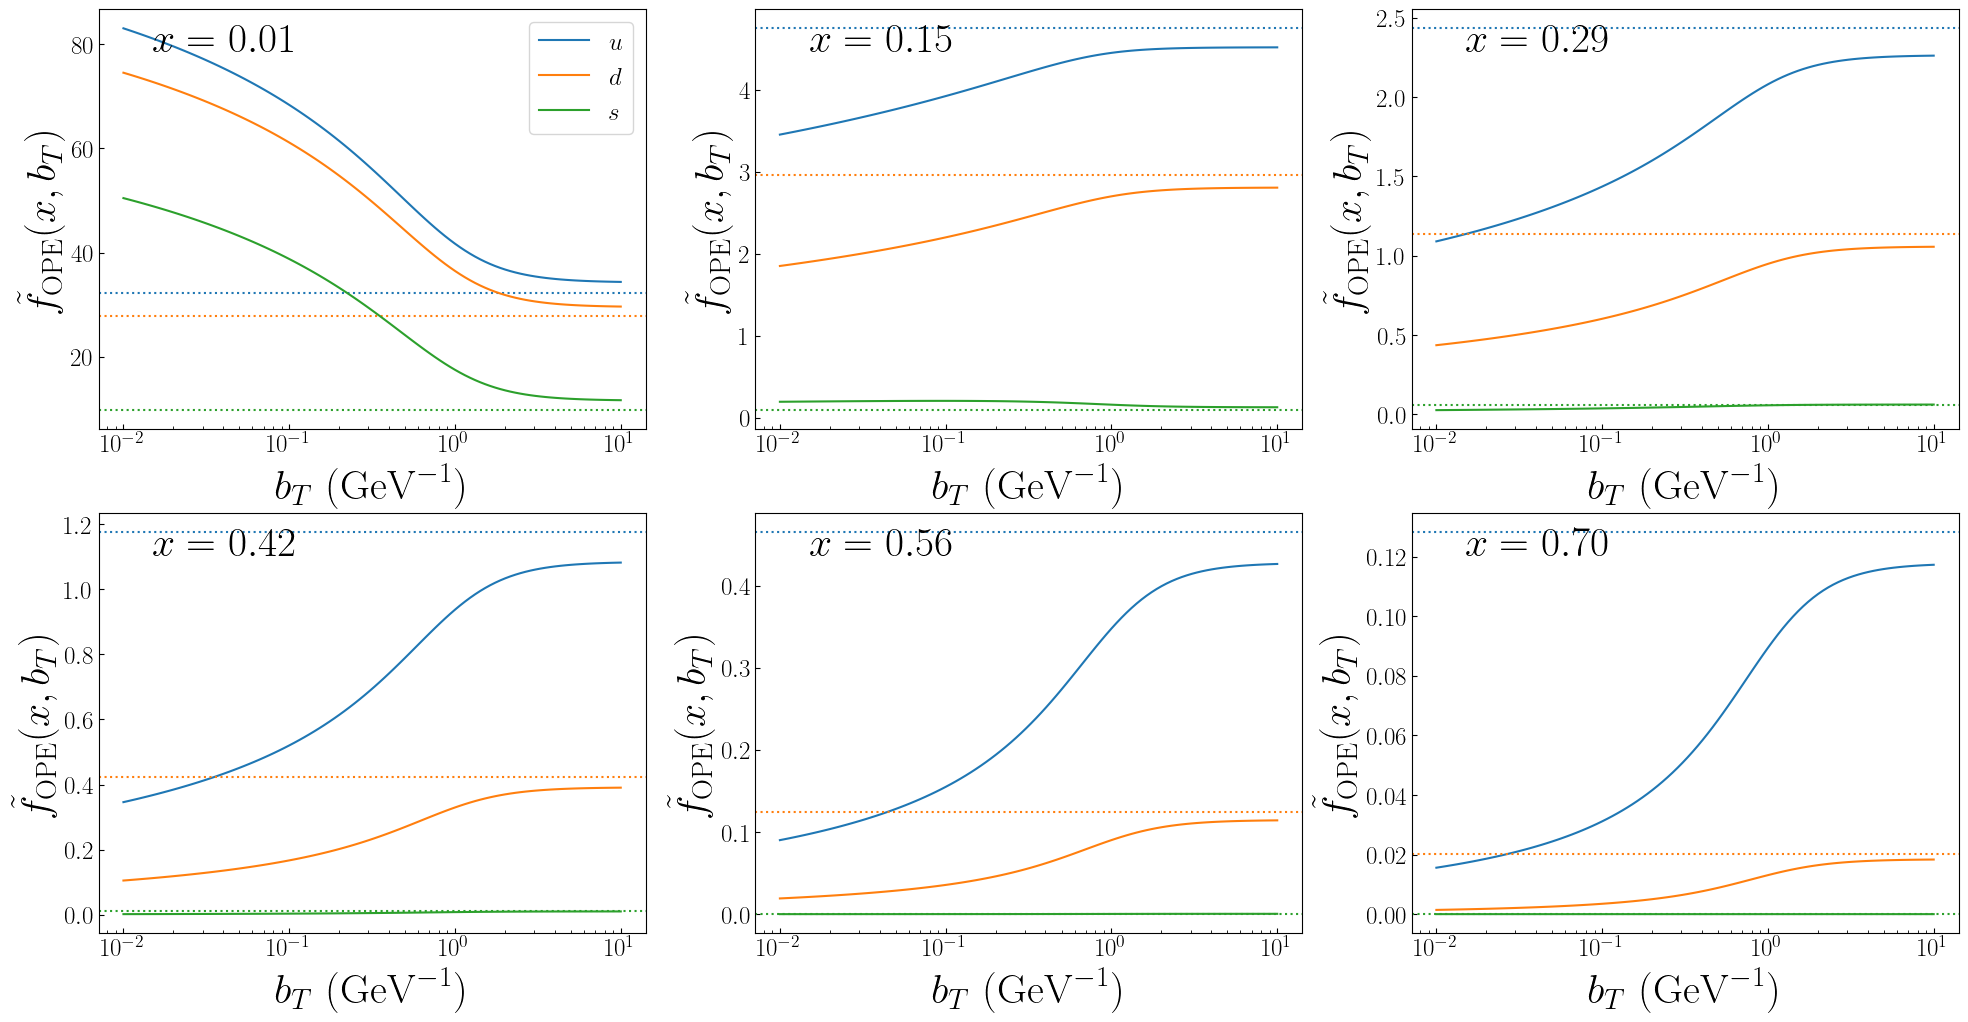

In [26]:
Xs = np.linspace(0.01,0.7,6)
bTs = 10**np.linspace(-2,1,100)

pdfope = PDF_OPE(pdf)

nrows,ncols=2,3
py.figure(figsize=(8*ncols,6*nrows))
cnt=0

flav_lab = [r'$g$',r'$u$',r'$d$',r'$s$',r'$c$',r'$b$',r'$\bar{b}$',r'$\bar{c}$',r'$\bar{s}$',r'$\bar{d}$',r'$\bar{u}$']
flavs = {r'$g$':'g',r'$u$':'u',r'$d$':'d',r'$s$':'s',r'$c$':'c',r'$b$':'b',r'$\bar{b}$':'bb',r'$\bar{c}$':'cb',r'$\bar{s}$':'sb',r'$\bar{d}$':'db',r'$\bar{u}$':'ub'}
for x in Xs:
    cnt+=1
    ax=py.subplot(nrows,ncols,cnt)

    opes = np.zeros((11,len(bTs)))
    for i in range(len(bTs)):
        opetmd = pdfope.get_OPE_TMDPDF(x,bTs[i])
        for j in range(len(opes)):
            opes[j][i] = opetmd[j]

    for i in range(len(opes)):
        if i in [0,4,5,6,7,8,9,10]: continue
        h,=ax.plot(bTs, opes[i],label=flav_lab[i])
        ax.axhline(y=pdf.get_xF(x,cfg.Q20,flavs[flav_lab[i]])/x,ls=':',c=h.get_color())

    ax.semilogx()
    ax.set_xlabel(r'$b_T~({\rm GeV}^{-1})$',size=30)
    ax.set_ylabel(r'$\tilde{f}_{\rm OPE}(x,b_T)$',size=30)
    ax.text(0.1,0.9,r'$x=%.2f$'%x,transform=ax.transAxes,size=30)
    if cnt==1: ax.legend(fontsize=18)
    ax.tick_params(direction='in',labelsize=18,which='both',axis='both')

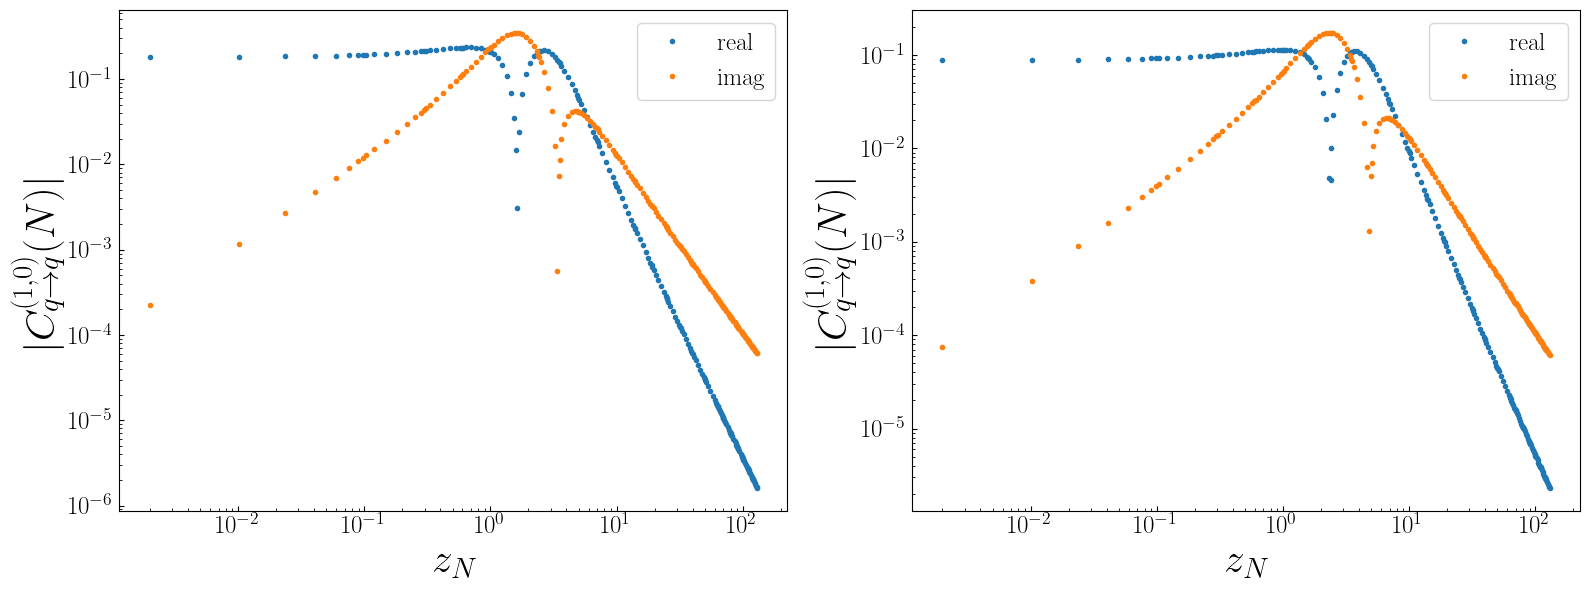

In [27]:
nrows,ncols = 1,2
py.figure(figsize=(8*ncols,6*nrows))

ax=py.subplot(nrows,ncols,1)
ax.plot(pdfope.mellin.Z,np.abs(pdfope.NLOq2.real),'.',label=r'$\rm real$')
ax.plot(pdfope.mellin.Z,np.abs(pdfope.NLOq2.imag),'.',label=r'$\rm imag$')
ax.set_xlabel(r'$z_N$',size=30)
ax.set_ylabel(r'$|C^{(1,0)}_{q \to q}(N)|$',size=30)
ax.tick_params(direction='in',labelsize=18,which='both',axis='both')
ax.legend(fontsize=18)
ax.semilogx()
ax.semilogy()

ax=py.subplot(nrows,ncols,2)
ax.plot(pdfope.mellin.Z,np.abs(pdfope.NLOg2.real),'.',label=r'$\rm real$')
ax.plot(pdfope.mellin.Z,np.abs(pdfope.NLOg2.imag),'.',label=r'$\rm imag$')
ax.set_xlabel(r'$z_N$',size=30)
ax.set_ylabel(r'$|C^{(1,0)}_{q \to q}(N)|$',size=30)
ax.tick_params(direction='in',labelsize=18,which='both',axis='both')
ax.legend(fontsize=18)
ax.semilogx()
ax.semilogy()
py.tight_layout()

iorder:  1
iorder:  0


/var/folders/g4/lx3qy8yd27q_qjssg5ksf0nh0000gr/T/ipykernel_77713/2203584528.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  py.tight_layout()


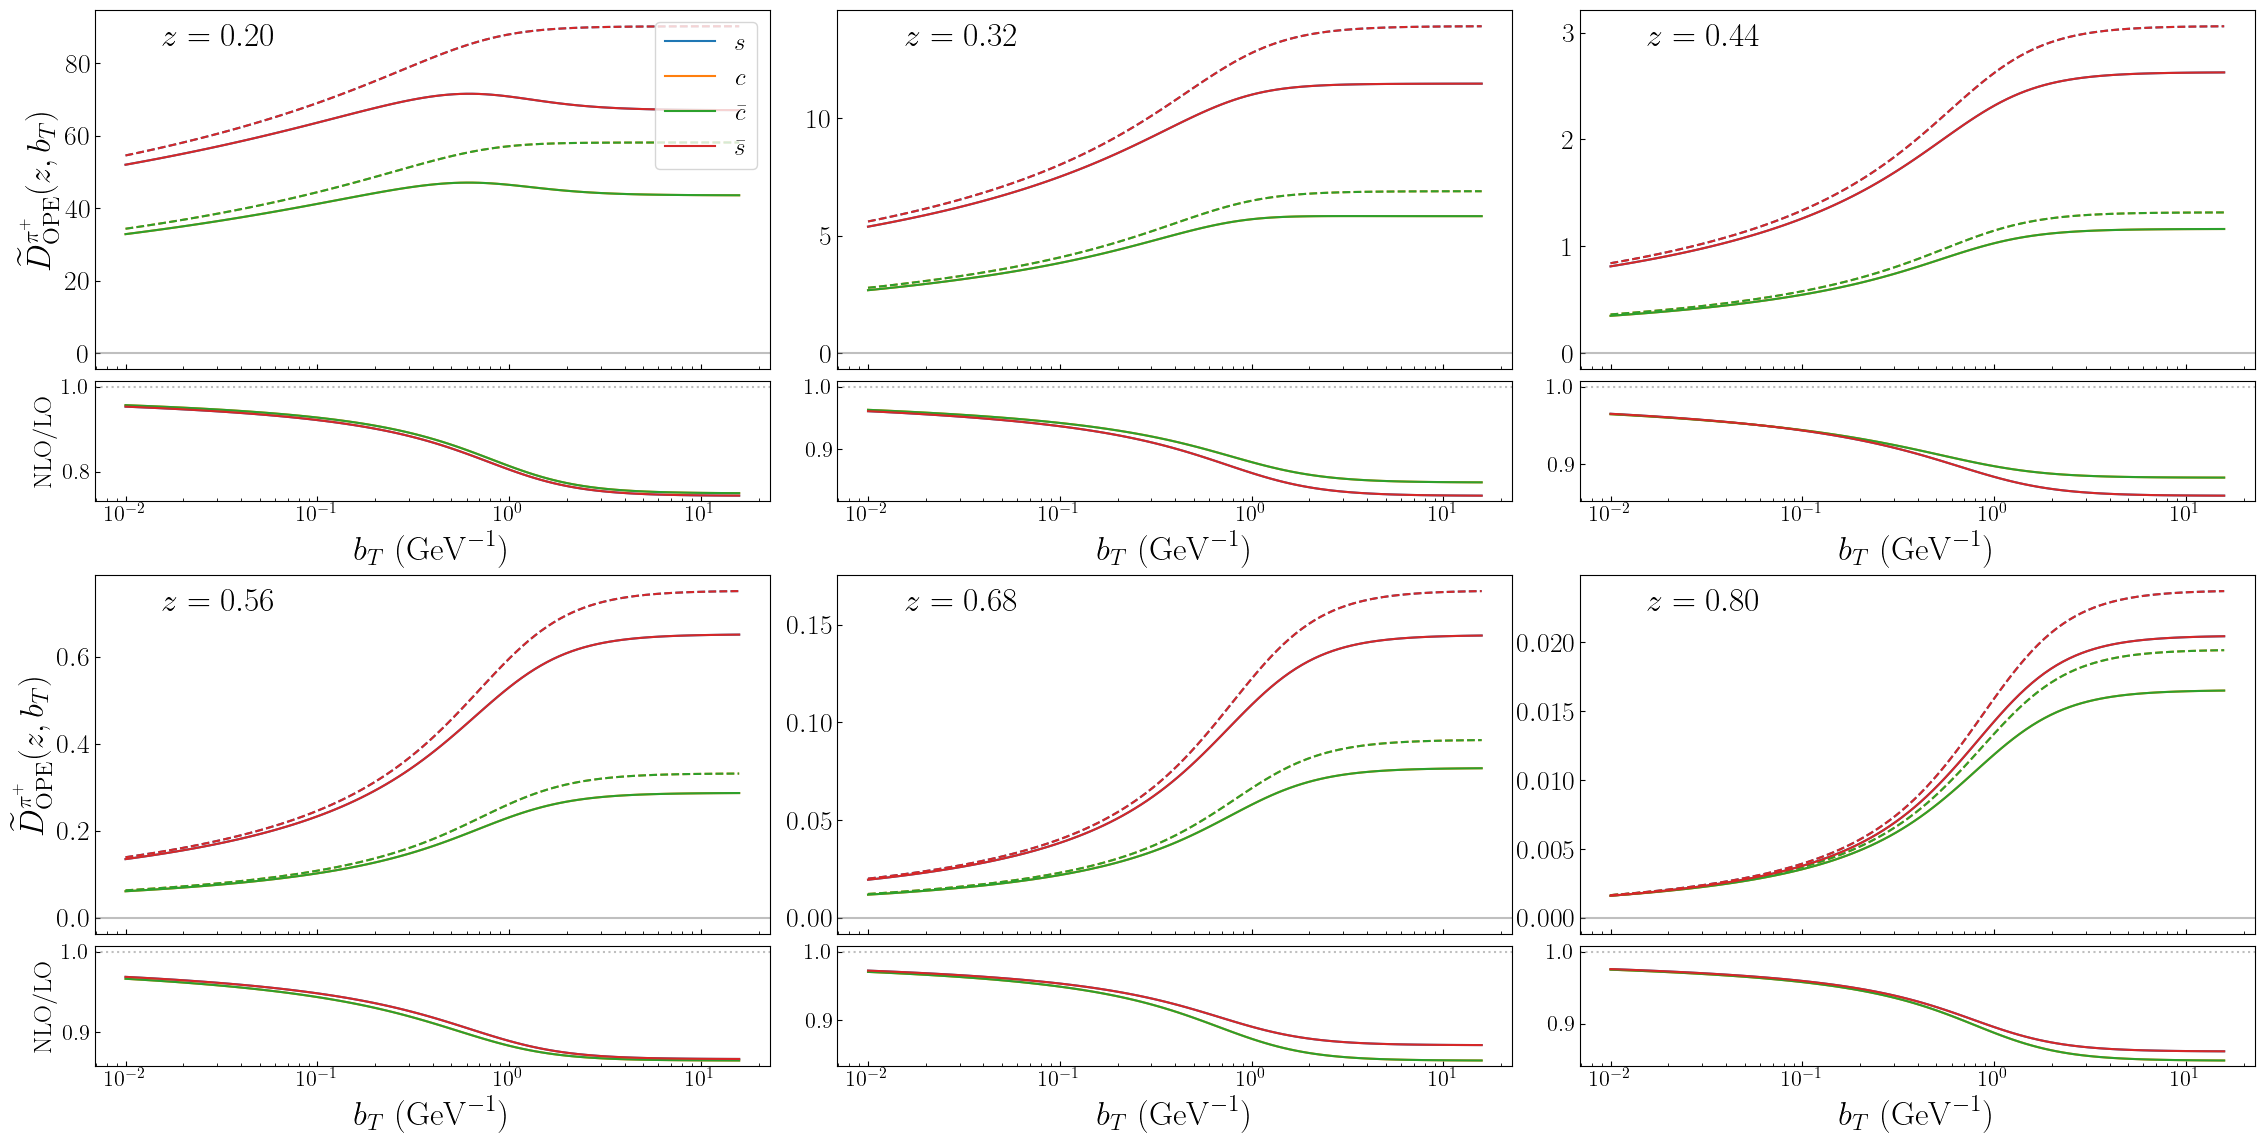

In [28]:
from matplotlib import gridspec

Zs = np.linspace(0.2,0.8,6)
bTs = 10**np.linspace(-2,1.2,100)

ffopeNLO = FF_OPE(ff)
ffopeLO = FF_OPE(ff,iorder=0)

nrows,ncols=2,3
fig = py.figure(figsize=(8*ncols,6*nrows))

# Create a grid-level gridspec with proper spacing
gs_outer = gridspec.GridSpec(nrows, ncols, figure=fig, 
                             hspace=0.15, wspace=0.10,
                             left=0.08, right=0.98, 
                             top=0.96, bottom=0.08)

flav_lab = [r'$g$',r'$u$',r'$d$',r'$s$',r'$c$',r'$b$',r'$\bar{b}$',r'$\bar{c}$',r'$\bar{s}$',r'$\bar{d}$',r'$\bar{u}$']
flavs = {r'$g$':'g',r'$u$':'u',r'$d$':'d',r'$s$':'s',r'$c$':'c',r'$b$':'b',r'$\bar{b}$':'bb',r'$\bar{c}$':'cb',r'$\bar{s}$':'sb',r'$\bar{d}$':'db',r'$\bar{u}$':'ub'}

for cnt, z in enumerate(Zs, 1):
    # Get position in grid
    row = (cnt-1) // ncols
    col = (cnt-1) % ncols
    
    # Create inner gridspec for this subplot with 2 rows (main + ratio)
    gs_inner = gridspec.GridSpecFromSubplotSpec(2, 1, 
                                                subplot_spec=gs_outer[row, col],
                                                height_ratios=[3, 1], 
                                                hspace=0.05)
    
    ax_main = fig.add_subplot(gs_inner[0])
    ax_ratio = fig.add_subplot(gs_inner[1], sharex=ax_main)

    opesnlo = np.zeros((11,len(bTs)))
    # opesnlo_zspace = np.zeros((11,len(bTs)))
    opeslo = np.zeros((11,len(bTs)))
    for i in range(len(bTs)):
        opetmdnlo = ffopeNLO.get_OPE_TMDFF(z,bTs[i])
        opetmdlo = ffopeLO.get_OPE_TMDFF(z,bTs[i])
        # opetmdnlo_zspace = ffopeNLO.get_OPE_TMDFF_zspace(z,bTs[i])
        for j in range(len(opesnlo)):
            opesnlo[j][i] = opetmdnlo[j]
            opeslo[j][i] = opetmdlo[j]
            # opesnlo_zspace[j][i] = opetmdnlo_zspace[j]

    # Main panel
    for i in range(len(opesnlo)):
        if i in [0,1,2,5,6,9,10]: continue
        h,=ax_main.plot(bTs, opesnlo[i],label=flav_lab[i])
        ax_main.plot(bTs, opeslo[i],c=h.get_color(),ls='--')
        # ax_main.plot(bTs, opesnlo_zspace[i],c=h.get_color(),ls=':',lw=3)
        # ax_main.axhline(y=1/z**2 *ff.get_xF(z,cfg.Q20,flavs[flav_lab[i]])/z,ls=':',c=h.get_color())
        
        # Ratio panel
        ratio = np.divide(opesnlo[i], opeslo[i], where=opeslo[i]!=0, out=np.ones_like(opesnlo[i]))
        ax_ratio.plot(bTs, ratio, c=h.get_color())

    ax_main.semilogx()
    if col==0: ax_main.set_ylabel(r'$\widetilde{D}^{\pi^+}_{\rm OPE}(z,b_T)$',size=24)
    ax_main.text(0.1,0.9,r'$z=%.2f$'%z,transform=ax_main.transAxes,size=24)
    if cnt==1: ax_main.legend(fontsize=18, loc='upper right')
    ax_main.tick_params(direction='in',labelsize=20,which='both',axis='both',labelbottom=False)
    ax_main.axhline(y=0,c='gray',alpha=0.5)
    
    # Ratio panel formatting
    ax_ratio.semilogx()
    ax_ratio.axhline(y=1, ls=':', c='gray', alpha=0.5)
    ax_ratio.set_xlabel(r'$b_T~({\rm GeV}^{-1})$',size=24)
    if col==0: ax_ratio.set_ylabel(r'$\rm NLO/LO$',size=18)
    ax_ratio.tick_params(direction='in',labelsize=16,which='both',axis='both')
    # ax_ratio.set_ylim([0.8, 1.2])  # Adjust as needed

    py.tight_layout()

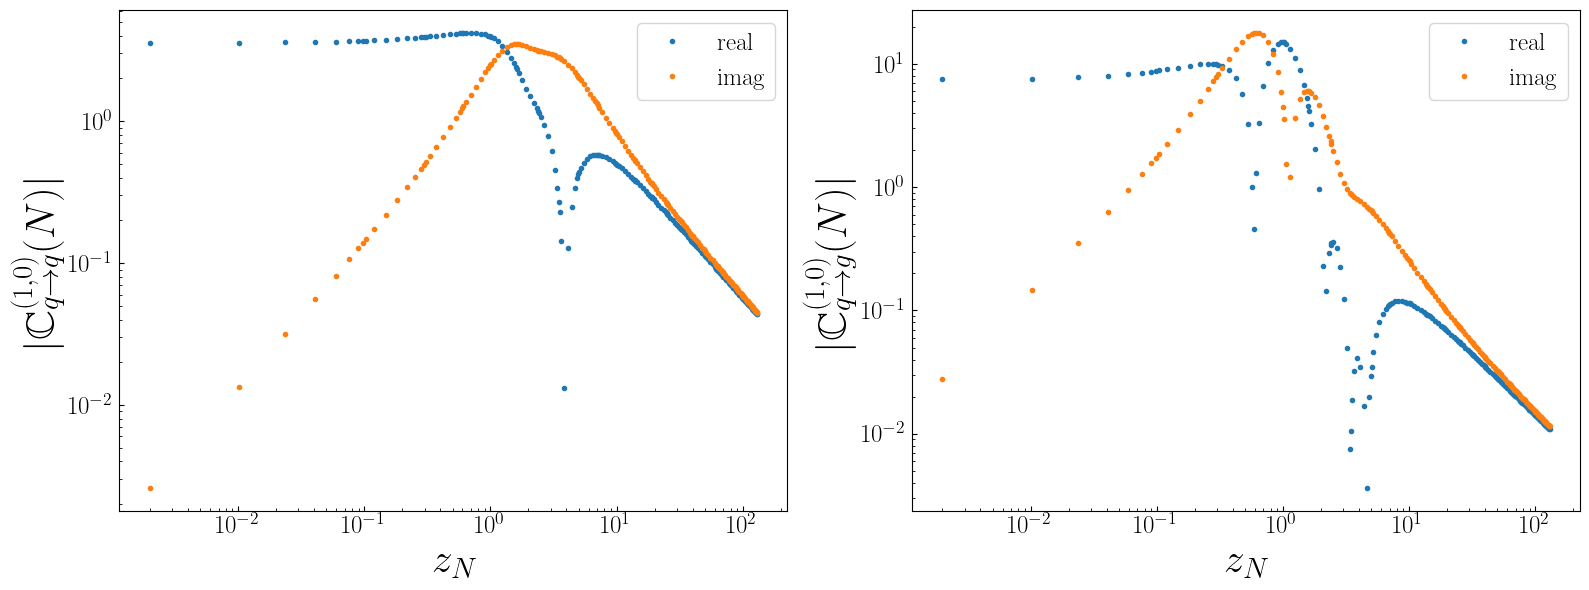

In [29]:
nrows,ncols = 1,2
py.figure(figsize=(8*ncols,6*nrows))

ax=py.subplot(nrows,ncols,1)
ax.plot(ffopeNLO.mellin.Z,np.abs(ffopeNLO.NLOq.real),'.',label=r'$\rm real$')
ax.plot(ffopeNLO.mellin.Z,np.abs(ffopeNLO.NLOq.imag),'.',label=r'$\rm imag$')
ax.set_xlabel(r'$z_N$',size=30)
ax.set_ylabel(r'$|\mathbb{C}^{(1,0)}_{q \to q}(N)|$',size=30)
ax.tick_params(direction='in',labelsize=18,which='both',axis='both')
ax.legend(fontsize=18)
ax.semilogx()
ax.semilogy()

ax=py.subplot(nrows,ncols,2)
ax.plot(ffopeNLO.mellin.Z,np.abs(ffopeNLO.NLOg.real),'.',label=r'$\rm real$')
ax.plot(ffopeNLO.mellin.Z,np.abs(ffopeNLO.NLOg.imag),'.',label=r'$\rm imag$')
ax.set_xlabel(r'$z_N$',size=30)
ax.set_ylabel(r'$|\mathbb{C}^{(1,0)}_{q \to g}(N)|$',size=30)
ax.tick_params(direction='in',labelsize=18,which='both',axis='both')
ax.legend(fontsize=18)
ax.semilogx()
ax.semilogy()

py.tight_layout()

In [30]:
class PERTURBATIVE_EVOLUTION:
    
    def __init__(self,alphaS,tmdmodel):

        self.iorder = cfg.tmd_resummation_order

        self.CF=params.CF
        self.CA=params.CA
        self.TR=params.TR
        self.TF=params.TF
        self.zeta2 = zeta(2)
        self.zeta3 = zeta(3)
        self.zeta4 = zeta(4)
        self.zeta5 = zeta(5)

        self.alphaS = alphaS
        self.tmdmodel=tmdmodel

        self.storage_Sudakov={}

    def reset_storage_Sudakov(self):
        self.storage_Sudakov={}


    #============================================================
    #--Setting up Gamma_cusp
    #============================================================
    """
    \$\Gamma\$-cusp

     notice the following correspondence from https://arxiv.org/pdf/1803.11089.pdf 

     Rogers17_PhysRevD.96.054011.pdf uses gamma_K = 2 gamma_Cusp
     - Cusp anomalous dimension expanded in alphaS, Eq. (59) of PhysRevD.96.054011
     """

    def get_Gamma0(self,mu):
        #--aS**1
        Nf=self.alphaS.get_Nf(mu**2)
        return 4. * self.CF

    def get_Gamma1(self,mu):
        #--aS**2
        Nf=self.alphaS.get_Nf(mu**2)
        return 4 * self.CF * (self.CA * (67/9 - np.pi**2/3)\
                   - 20/9 * self.TR * Nf)

    def get_Gamma2(self,mu):
        #--aS**3
        Nf=self.alphaS.get_Nf(mu**2)
        return 4 * self.CF *(self.CA**2 * (245/6 - 134/27*np.pi**2 + 11/45*np.pi**4 + 22/3*self.zeta3) \
                    + self.CA * self.TR * Nf * (-418/27 + 40/27*np.pi**2 - 56/3*self.zeta3)\
                    + self.CF * self.TR * Nf * (-55/3 + 16 * self.zeta3) - 16/27 * self.TR**2 * Nf**2 )

    def get_Gamma3(self,mu):
        #--aS**4
        Nf=self.alphaS.get_Nf(mu**2)
        dFA=15/16 #--d_F^{abcd}d_A^{abcd}/(N^2-1)
        dFF=5/96 #--d_F^{abcd}d_F^{abcd}/(N^2-1)

        return  self.CF*( \
                dFA*(7040/3*self.zeta5 +256/3*self.zeta3-768*(self.zeta3**2) -256*self.zeta2 -15872/35*(self.zeta2**3))\
                +dFF*Nf*(-2560/3*self.zeta5 -512/3*self.zeta3 +512*self.zeta2)\
                +(Nf**3)*(-32/81 +64/27*self.zeta3)\
                +self.CF*(Nf**2)*(2392/81 -640/9*self.zeta3 +64/5*(self.zeta2**2))\
                +(self.CF**2)*Nf*(572/9 -320*self.zeta5 +592/3*self.zeta3)\
                +self.CA*(Nf**2)*(923/81 +2240/27*self.zeta3 -608/81*self.zeta2 -224/15*(self.zeta2**2))\
                +self.CF*self.CA*Nf*(-34066/81 +160*self.zeta5 +3712/9*self.zeta3 +440/3*self.zeta2 -128*self.zeta2*self.zeta3 -352/5*(self.zeta2**2))\
                +(self.CA**2)*Nf*(-24137/81 +2096/9*self.zeta5 -23104/27*self.zeta3 +20320/81*self.zeta2 \
                +448/3*self.zeta2*self.zeta3 -352/15*(self.zeta2**2))\
                +(self.CA**3)*(84278/81 - 3608/9*self.zeta5 +20944/27*self.zeta3 -16*(self.zeta3**2) \
                -88400/81*self.zeta2 -352/3*self.zeta2*self.zeta3 +3608/5*(self.zeta2**2)-20032/105*(self.zeta2**3)))     


    #============================================================
    #--Setting up gamma_J
    #============================================================
    """
    Here we calculate the \$\gamma_{J}\$ Eq. (58) of PhysRevD.96.054011
    """
    def get_gammaJ1(self,mu):
        #--aS**1
        Nf=self.alphaS.get_Nf(mu**2)
        return 6. * self.CF

    def get_gammaJ2(self,mu):
        #--aS**2
        Nf=self.alphaS.get_Nf(mu**2)
        return  self.CF**2 * (3. - 4. * np.pi**2 + 48. * self.zeta3)\
                        + self.CF * self.CA * (961./27. + 11. * np.pi**2/3. - 52. * self.zeta3)\
                        + self.CF * Nf * (-130./27. - 2. * np.pi**2/3.) 

    def get_gammaJ3(self,mu):
        #--aS**3
        Nf=self.alphaS.get_Nf(mu**2)
        return  self.CF**2 * Nf * (-2953./27. + 26. * np.pi**2/9 + 28. * np.pi**4/27 - 512. * self.zeta3/9.)\
                        + self.CF * Nf**2 * (-4834./729. + 20. * np.pi**2/27. + 16. * self.zeta3/27. )\
                        + self.CF**3 * (29. + 6. * np.pi**2 + 16. * np.pi**4/5. + 136. * self.zeta3 - 32. * np.pi**2 * self.zeta3/3. - 480. * self.zeta5)\
                        + self.CA**2 * self.CF * (139345./1458. + 7163. * np.pi**2/243. + 83. * np.pi**4/45. - 7052. * self.zeta3/9. + 88. * np.pi**2 * self.zeta3/9. + 272. * self.zeta5 )\
                        + self.CA * self.CF * Nf * (17318./729. - 2594. * np.pi**2/243. - 22. * np.pi**4/45. + 1928. * self.zeta3/27.)\
                        + self.CA * self.CF**2 * (151./2. - 410. * np.pi**2/9. - 494. * np.pi**4/135. + 1688. * self.zeta3/3. + 16. * np.pi**2 * self.zeta3/3. + 240. * self.zeta5)


    #============================================================
    #--Setting up perturbative evolution
    #============================================================
    """
    Perturbative part of the evolution  (perturbative Sudakov and Collins-Soper kernel)

    for gamma3 we use Eq. (D9) on p. 36 of 1604.07869, using that Ktilde =  -2D
    """

    def get_Ktilde(self,bT,mu):
        """
        Collins-Soper kernel at small bT can be expanded in alphaS, Eq. (69) of PhysRevD.96.054011
        """

        aS=self.alphaS.get_a(mu**2) #- alphaS/(4 pi)
        log=self.tmdmodel.get_Log(bT,mu) #- Typical logarithm
        Nf=self.alphaS.get_Nf(mu**2)

        ##### for N3LL term - see 1604.07869 #####
        Gamma1 = 1
        Gamma2 = (67/9-np.pi**2/3)*self.CA - (20/9)*self.TR*Nf
        Gamma3 = self.CA**2*(245/6 - 134*np.pi**2/27 + 11*np.pi**4/45 + 22*self.zeta3/3) \
                        + self.CA*self.TR*Nf*(-418/27 + 40*np.pi**2/27 - 56*self.zeta3/3) \
                        + self.CF*self.TR*Nf*(-55/3 + 16*self.zeta3) - (16/27)*self.TR**2*Nf**2
        beta1 = (11/3)*self.CA - (4/3)*self.TR*Nf # 
        beta2 = 34*self.CA**2/3 - 20*self.CA*self.TR*Nf/3 - 4*self.CF*self.TR*Nf # 

        d20 = self.CA*(404/27 - 14*self.zeta3) - 112*self.TR*Nf/27
        d33 = (2/3)*Gamma1*beta1**2
        d32 = 2*Gamma2*beta1 + Gamma1*beta2
        d31 = 2*beta1*d20 + 2*Gamma3
        d30 = (-self.CA**2/2)*(-176*self.zeta3*self.zeta2/3 + 6392*self.zeta2/81 + 12328*self.zeta3/27 + 154*self.zeta4/3 - 192*self.zeta5 - 297029/729) \
                    - self.CA*self.TR*Nf*(-824*self.zeta2/81 - 904*self.zeta3/27 + 20*self.zeta4/3 + 62626/729) \
                    - 2*self.TR**2*Nf**2*(-32*self.zeta3/9 - 1856/729) \
                    - self.CF*self.TR*Nf*(-304*self.zeta3/9 - 16*self.zeta4 + 1711/27)
        ######################################

        Ktilde = 0

        if self.iorder>0: 

            Ktilde += -8 * self.CF * aS * log

        if self.iorder>1:

            Ktilde += 8 * self.CF * aS**2 * (  \
                        +  (2/3 * Nf - 11/3 * self.CA) * log**2 \
                        +  (-67/9 * self.CA + np.pi**2/3 * self.CA + 10/9 * Nf) * log \
                        +  (7/2 * self.zeta3 - 101/27) * self.CA + 14/27 * Nf )

        if self.iorder>2: # Eq. (D9) on p. 36 of 1604.07869, using that Ktilde =  -2D

            Ktilde += -2*self.CF*aS**3 * (d30 +  2*log*d31 + 4*log**2*d32 + 8*log**3*d33) #see 1604.07869

        return Ktilde


    def get_gammaF(self,mu):
        """
        Anomalous dimension of TMD operator expanded in alphaS, Eq. (58) of PhysRevD.96.054011
        """

        aS=self.alphaS.get_a(mu**2) #- alphaS/(4 pi)

        gammaF = 0

        if self.iorder>0:
            GAMMA1 = self.get_gammaJ1(mu)
            gammaF += GAMMA1 * aS

        if self.iorder>1:
            GAMMA2 = self.get_gammaJ2(mu)           
            gammaF += aS**2 * GAMMA2

        if self.iorder>2:
            GAMMA3 = self.get_gammaJ3(mu)
            gammaF += aS**3 * GAMMA3

        return gammaF

    def get_gammaK(self,mu):
        """
        Cusp anomalous dimension expanded in alphaS, Eq. (59) of PhysRevD.96.054011
        """

        aS=self.alphaS.get_a(mu**2) #- alphaS/(4 pi)

        gamma0 = self.get_Gamma0(mu)        
        gammaK = 2 * gamma0 * aS

        if self.iorder>0: 
            gamma1 = self.get_Gamma1(mu)
            gammaK += aS**2 * 2 * gamma1

        if self.iorder>1:
            gamma2 = self.get_Gamma2(mu)
            gammaK += aS**3 * 2 * gamma2

        if self.iorder>2:
            gamma3 = self.get_Gamma3(mu)
            gammaK += aS**4 * 2 * gamma3

        return gammaK

    def get_integrand_gammas(self,mup,zeta):
        return 1/mup*(self.get_gammaF(mup)-np.log(np.sqrt(zeta)/mup)*self.get_gammaK(mup))


    def get_Sudakov_perturbative(self,muQ,zeta,bT):
        """
        perturbative part of the evolution in the solution 
        maximizing perturbative precision, 
        Eq. (26) of PhysRevD.96.054011 
        Returns perturbative Sudakov using b* and mub* 
        """
        mub   = self.tmdmodel.get_mub(bT) # returns mub*
        bstar = self.tmdmodel.get_bstar(bT) # returns b*

        key = (muQ,zeta,bstar)
        if key not in self.storage_Sudakov:
            integral_gammas=quad(lambda mup: self.get_integrand_gammas(mup,zeta),mub,muQ)[0]            
            self.storage_Sudakov[key]=np.log(np.sqrt(zeta)/mub)*self.get_Ktilde(bstar,mub) + integral_gammas
        return self.storage_Sudakov[key] 

    def get_exp_Sudakov_perturbative(self,Q,bT):
        """
        Exponential of perturbative part of the evolution 
        in the solution maximizing perturbative precision, 
        Eq. (26) of PhysRevD.96.054011


        For the purposes of this code, I am assuming that zeta=Q**2 and that muQ = Q.
        This does not necessarily have to happen!
        """
        muQ = Q
        zeta = Q**2
        return np.exp(self.get_Sudakov_perturbative(muQ,zeta,bT)) 


In [31]:
pertevo = PERTURBATIVE_EVOLUTION(alphaS,tmdmodel)

In [32]:

bTs = 10**np.linspace(-2,2,100)
# Q = np.linspace(3,10,50)
Q = np.array([np.sqrt(cfg.Q20)])

sud = np.zeros((len(bTs),len(Q)))
for i in range(len(bTs)):
    for j in range(len(Q)):
        # sud.append(pertevo.get_exp_Sudakov_perturbative(Q,bTs[i]))
        sud[i][j] = pertevo.get_exp_Sudakov_perturbative(Q[j],bTs[i])
#sud=np.array(sud)


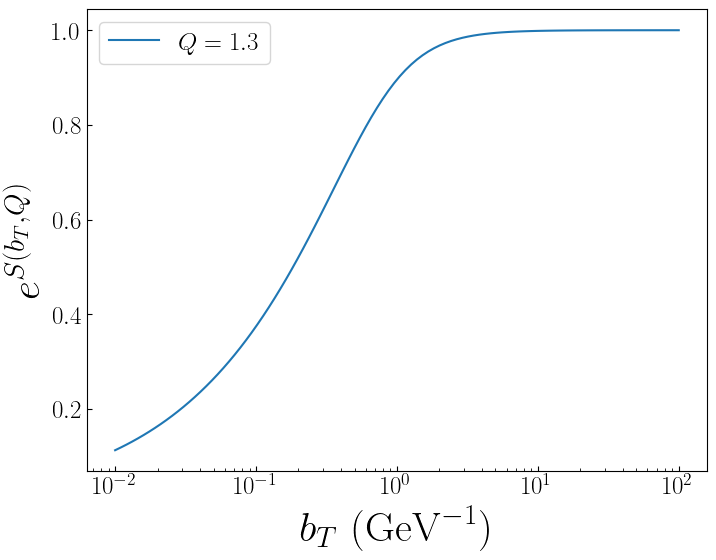

In [33]:
nrows,ncols = 1,1
py.figure(figsize=(8*ncols,6*nrows))
ax=py.subplot(nrows,ncols,1)

idx = 0
ax.plot(bTs,sud.T[idx],label=r'$Q=%.1f$'%Q[idx])
ax.semilogx()
ax.set_xlabel(r'$b_T~({\rm GeV}^{-1})$',size=30)
ax.set_ylabel(r'$e^{S(b_T,Q)}$',size=30)
ax.tick_params(direction='in',labelsize=18,which='both',axis='both')
ax.legend(fontsize=18)

## Test of evolution from mub* to Q0

In [34]:
bTs = 10**np.linspace(-3,np.log10(20),500)
Q0 = np.sqrt(cfg.Q20)

In [35]:
mubs = pertevo.tmdmodel.get_mub(bTs)
bstars = pertevo.tmdmodel.get_bstar(bTs)

new_sud = np.zeros(len(bTs))
for i in range(len(bTs)):
    key = (Q0,Q0**2,bstars[i])
    if True:#key not in pertevo.storage_Sudakov:
        integral_gammas=quad(lambda mup: pertevo.get_integrand_gammas(mup,Q0**2),mubs[i],Q0)[0]
        pertevo.storage_Sudakov[key]=np.log(np.sqrt(Q0**2)/mubs[i])*pertevo.get_Ktilde(bstars[i],mubs[i]) + integral_gammas
        # pertevo.storage_Sudakov[key]=integral_gammas
    new_sud[i] = pertevo.storage_Sudakov[key]

new_sud = np.exp(new_sud)


In [36]:
from sidis.model.evolution import PERTURBATIVE_EVOLUTION as PERTURBATIVE_EVOLUTION_NEW

In [37]:
evo = PERTURBATIVE_EVOLUTION_NEW(order=cfg.tmd_resummation_order)

In [38]:
bstars_torch = torch.tensor(bstars, dtype=torch.float64)
mubs_torch = torch.tensor(mubs, dtype=torch.float64)
Q0_torch = torch.tensor(Q0, dtype=torch.float64)
rap_evo = torch.exp(evo.get_Ktilde(bstars_torch, mubs_torch) * torch.log(Q0/mubs_torch))
# rap_evo = torch.exp(evo.get_Ktilde(torch.tensor(bstars),torch.tensor(mubs)) * torch.log(Q0/torch.tensor(mubs)))

alphaS_mub = evo.alphaS.get_alphaS(torch.tensor(mubs,dtype=torch.float64)**2)
alphaS_Q0 = evo.alphaS.get_alphaS(torch.tensor(Q0,dtype=torch.float64)**2)
Nf0,Nf = 4,4 #--this is because we are taking Nf=4 everywhere. We need to think about how to handle this later.
eta_Gamma, K_gamma, K_Gamma = evo.compute_evolution_components(alphaS_mub, alphaS_Q0, Nf0, Nf)
# RGE_factor = torch.exp(-K_gamma + 0.5 * torch.log(Q0**2/torch.tensor(mubs)**2) * eta_Gamma - K_Gamma).real
RGE_factor = torch.exp(-K_gamma - K_Gamma).real
# print('evolution factor: ', evolution_factor)
evolution_factor = rap_evo * RGE_factor
# evolution_factor = rap_evo
# evolution_factor = RGE_factor

In [39]:
eta_Gamma, K_gamma, K_Gamma = evo.compute_evolution_components(alphaS_mub, alphaS_Q0,  Nf0, Nf)
RGE_factor = torch.exp(-K_gamma + torch.log(Q0_torch/mubs_torch) * eta_Gamma - K_Gamma).real

In [40]:
print("Notebook alphaS.a0:", alphaS.a0)
print("Sidis alphaS.a0:", evo.alphaS.a0)
print("Notebook cfg.Q20:", cfg.Q20)  

Notebook alphaS.a0: 0.03731187117366759
Sidis alphaS.a0: 0.03731187117366759
Notebook cfg.Q20: 1.6384


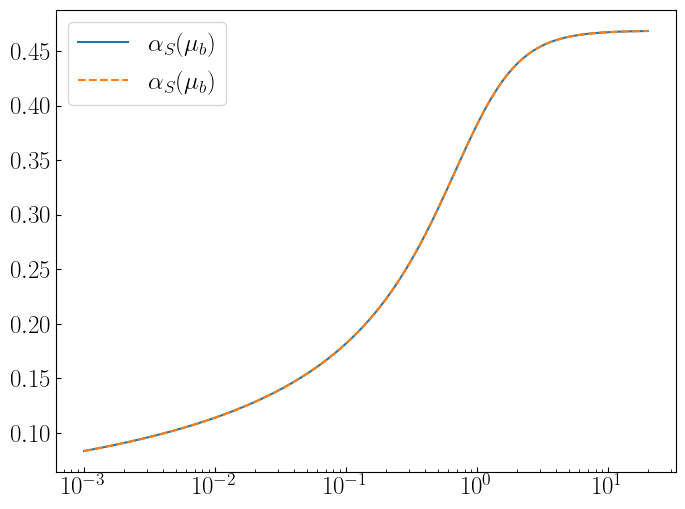

In [41]:
nrows,ncols = 1,1
py.figure(figsize=(8*ncols,6*nrows))
ax=py.subplot(nrows,ncols,1)

ax.plot(bTs,alphaS_mub,label=r'$\alpha_S(\mu_b)$')
pertevoalphaS=[]
for mub in mubs:
    pertevoalphaS.append(pertevo.alphaS.get_alphaS(mub**2))
ax.plot(bTs,pertevoalphaS,'--',label=r'$\alpha_S(\mu_b)$')
# ax.plot(bTs,mubs,label=r'$\alpha_S(mub)$')
# ax.plot(bTs,torch.tensor(mubs),label=r'$\alpha_S(mub)$')

ax.semilogx()
# ax.semilogy()
ax.tick_params(direction='in',labelsize=18,which='both',axis='both')
ax.legend(fontsize=18)

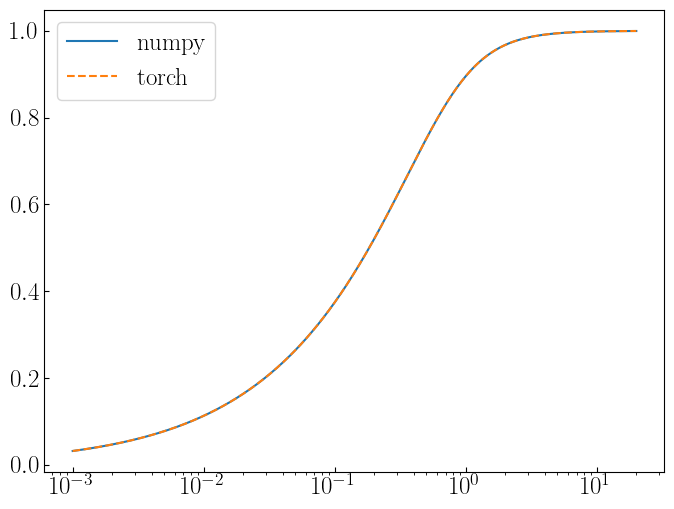

In [42]:
nrows,ncols = 1,1
py.figure(figsize=(8*ncols,6*nrows))
ax = py.subplot(nrows,ncols,1)

ax.plot(bTs,new_sud,label=r'$\rm numpy$')
ax.plot(bTs,evolution_factor,ls='--',label=r'$\rm torch$')
# ax.plot(bTs,(evolution_factor - new_sud)/new_sud*100)
ax.tick_params(direction='in',labelsize=18)
ax.semilogx()
ax.legend(fontsize=18)

In [43]:
def get_fNP(x,bT):
    # check for the flavor-blind case first
    def get_g(x,N,sig,alp):
        xhat = 0.1
        return N * x**sig * (1-x)**(alp**2) / (xhat**sig * (1-xhat)**(alp**2))
    
    N1,alp1,sig1,lam,N1b,N1c,lam2,alp2,alp3,sig2,sig3 = 0.28516, 2.9755, 0.17293, 0.39432, 0.28516, 0.28516, 0.39432, 2.9755, 2.9755, 0.17293, 0.17293

    g1 = get_g(x,N1,sig1,alp1)
    g1b = get_g(x,N1b,sig2,alp2)
    g1c = get_g(x,N1c,sig3,alp3)

    fNP_num = (g1 * np.exp(-bT**2 / 4 * g1) + lam**2 * g1b**2 * (1 - g1b * bT**2 / 4) * np.exp(-bT**2 / 4 * g1b) + lam2**2 * g1c * np.exp(-bT**2 / 4 * g1c))
    fNP_den = g1 + lam**2 * g1b**2 + lam2**2 * g1c

    return fNP_num / fNP_den

[]

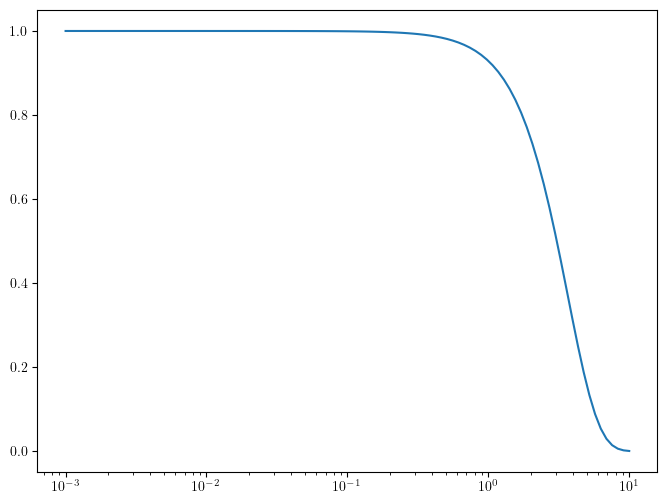

In [44]:
nrows,ncols=1,1
py.figure(figsize=(8*ncols,6*nrows))
ax=py.subplot(nrows,ncols,1)
BT = 10**np.linspace(-3,1,100)
x = 0.1
ax.plot(BT,get_fNP(x,BT))
ax.semilogx()

In [45]:
def get_DNP(z,bT):
    # check for the flavor-blind case first
    def get_g(z,N,bet,delt,gamm):
        zhat = 0.5
        return N * ((z**bet + delt**2) * (1 - z)**(gamm**2)) / ((zhat**bet + delt**2) * (1 - zhat)**(gamm**2))
    N3,bet1,delt1,gamm1,lamF,N3b,bet2,delt2,gamm2 = 0.21012, 2.12062, 0.093554, 0.25246, 5.2915, 0.033798, 2.1012, 0.093554, 0.25246

    g3 = get_g(z,N3,bet1,delt1,gamm1)
    g3b = get_g(z,N3b,bet2,delt2,gamm2)

    DNP_num = (g3 * np.exp(-g3 * bT**2 / 4 / z**2) + lamF / z**2 * g3b**2 * (1 - g3b * bT**2 / 4 / z**2) * np.exp(-g3b * bT**2 / 4 / z**2))
    DNP_den = g3 + lamF / z**2 * g3b**2

    return DNP_num / DNP_den

[]

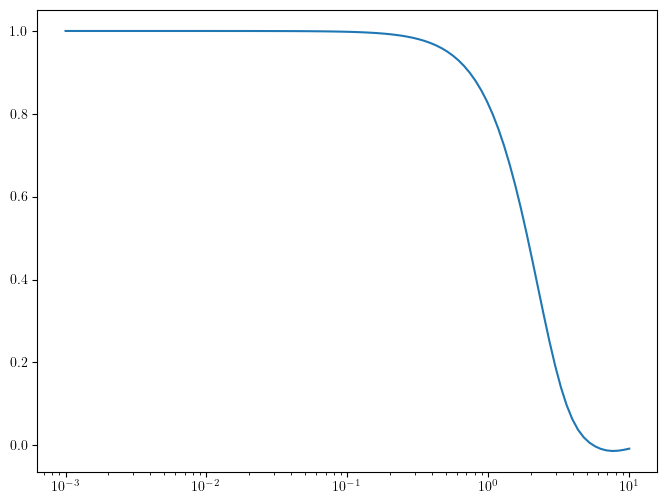

In [46]:
nrows,ncols=1,1
py.figure(figsize=(8*ncols,6*nrows))
ax=py.subplot(nrows,ncols,1)
BT = 10**np.linspace(-3,1,100)
z = 0.5
ax.plot(BT,get_DNP(z,BT))
ax.semilogx()

In [47]:
def get_NP_evo(bT,Q):
    g2 = 0.12840
    #return (Q**2 / cfg.Q20) **(-g2**2 * bT**2 / 4)
    return (Q**2 / 1) **(-g2**2 * bT**2 / 4)

[]

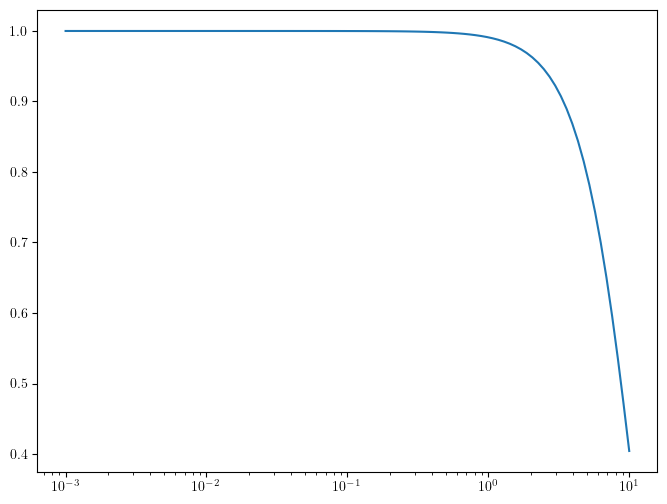

In [48]:
nrows,ncols=1,1
py.figure(figsize=(8*ncols,6*nrows))
ax=py.subplot(nrows,ncols,1)
BT = 10**np.linspace(-3,1,100)
Q=3
ax.plot(BT,get_NP_evo(BT,Q))
ax.semilogx()

In [49]:
Q20 = torch.tensor(cfg.Q20,dtype=torch.float64)

In [50]:
bTs[:4]

x = 0.1
PhT = 0.1
Q = 3
z = 0.3

# Q2 = torch.tensor(Q,dtype=torch.float64)**2
# evo_from_q0_to_Q = evo(bTs,Q20,Q2)
# print(evo_from_q0_to_Q[0].shape)

def get_integrand(bT,x,z,Q,Q0=cfg.Q20**0.5):
    flavs = ['u','d','s','c','cb','sb','db','ub']
    eq2 = {'u': 4/9, 'd':1/9, 's':1/9, 'c':4/9, 'cb':4/9, 'sb':1/9, 'db':1/9, 'ub':4/9}
    fmap = {'u':1,'d':2,'s':3,'c':4,'cb':-4,'sb':-3,'db':-2,'ub':-1,'g':0}

    bstar = torch.tensor(tmdmodel.get_bstar(bT), dtype=torch.float64)
    mub = torch.tensor(tmdmodel.get_mub(bT), dtype=torch.float64)
    
    Q0_torch = torch.tensor(Q0, dtype=torch.float64)
    rap_evo = torch.exp(evo.get_Ktilde(bstar, mub) * torch.log(Q0/mub))

    alphaS_mub = evo.alphaS.get_alphaS(torch.tensor(mub,dtype=torch.float64)**2)
    alphaS_Q0 = evo.alphaS.get_alphaS(torch.tensor(Q0,dtype=torch.float64)**2)
    Nf0,Nf = 4,4 #--this is because we are taking Nf=4 everywhere. We need to think about how to handle this later.
    eta_Gamma, K_gamma, K_Gamma = evo.compute_evolution_components(alphaS_mub, alphaS_Q0, Nf0, Nf)
    RGE_factor = torch.exp(-K_gamma - K_Gamma).real
    evolution_factor = rap_evo * RGE_factor

    Q2 = torch.tensor(Q,dtype=torch.float64)**2
    evo_from_q0_to_Q = evo(bT,Q20,Q2)
    #print(evo_from_q0_to_Q)
    intgd = 0
    bT = bT.item()
    for f in flavs:
        intgd += eq2[f] * pdfope.get_OPE_TMDPDF(x,bT)[fmap[f]] * ffopeNLO.get_OPE_TMDFF(z,bT)[fmap[f]] * evolution_factor**2 * evo_from_q0_to_Q**2 * get_fNP(x,bT) * get_DNP(z,bT) * get_NP_evo(bT,Q)**2
        #print('f',f,'pdfope.get_OPE_TMDPDF(x,bT)[fmap[f]]',pdfope.get_OPE_TMDPDF(x,bT)[fmap[f]] * evolution_factor)
        #intgd += pdfope.get_OPE_TMDPDF(x,bT)[fmap[f]] * evolution_factor
        # print('f',f,'x',x,'z',z,'bT',bT,'fNP',get_fNP(x,bT),'DNP',get_DNP(z,bT),'NP_evo',get_NP_evo(bT,Q))
    return intgd


In [51]:
evo.order

2

In [52]:
get_fNP(0.1,0.0010000000474974513)

np.float64(0.9999999260755084)

In [53]:
bTs = torch.tensor([1.0000e-03, 5.2689e-03, 1.2949e-02, 2.4042e-02, 3.8548e-02, 5.6468e-02,
         7.7800e-02, 1.0255e-01, 1.3070e-01, 1.6228e-01, 1.9726e-01, 2.3566e-01,
         2.7747e-01, 3.2270e-01, 3.7134e-01, 4.2339e-01, 4.7885e-01, 5.3773e-01,
         6.0002e-01, 6.6572e-01, 7.3484e-01, 8.0737e-01, 8.8331e-01, 9.6267e-01,
         1.0454e+00, 1.1316e+00, 1.2212e+00, 1.3142e+00, 1.4106e+00, 1.5105e+00,
         1.6137e+00, 1.7204e+00, 1.8305e+00, 1.9440e+00, 2.0609e+00, 2.1812e+00,
         2.3049e+00, 2.4320e+00, 2.5626e+00, 2.6965e+00, 2.8339e+00, 2.9747e+00,
         3.1189e+00, 3.2665e+00, 3.4176e+00, 3.5720e+00, 3.7299e+00, 3.8911e+00,
         4.0558e+00, 4.2239e+00, 4.3954e+00, 4.5703e+00, 4.7487e+00, 4.9304e+00,
         5.1156e+00, 5.3041e+00, 5.4961e+00, 5.6915e+00, 5.8903e+00, 6.0925e+00,
         6.2982e+00, 6.5072e+00, 6.7197e+00, 6.9355e+00, 7.1548e+00, 7.3775e+00,
         7.6036e+00, 7.8331e+00, 8.0661e+00, 8.3024e+00, 8.5422e+00, 8.7854e+00,
         9.0319e+00, 9.2819e+00, 9.5353e+00, 9.7922e+00, 1.0052e+01, 1.0316e+01,
         1.0583e+01, 1.0854e+01, 1.1127e+01, 1.1405e+01, 1.1685e+01, 1.1970e+01,
         1.2257e+01, 1.2548e+01, 1.2842e+01, 1.3140e+01, 1.3441e+01, 1.3746e+01,
         1.4054e+01, 1.4365e+01, 1.4680e+01, 1.4998e+01, 1.5320e+01, 1.5645e+01,
         1.5974e+01, 1.6305e+01, 1.6641e+01, 1.6979e+01, 1.7321e+01, 1.7667e+01,
         1.8016e+01, 1.8368e+01, 1.8724e+01, 1.9083e+01, 1.9446e+01, 1.9812e+01,
         2.0181e+01, 2.0554e+01, 2.0930e+01, 2.1310e+01, 2.1693e+01, 2.2079e+01,
         2.2469e+01, 2.2863e+01, 2.3259e+01, 2.3659e+01, 2.4063e+01, 2.4470e+01,
         2.4880e+01, 2.5294e+01, 2.5711e+01, 2.6132e+01, 2.6556e+01, 2.6983e+01,
         2.7414e+01, 2.7848e+01, 2.8286e+01, 2.8727e+01, 2.9171e+01, 2.9619e+01,
         3.0070e+01, 3.0525e+01, 3.0983e+01, 3.1444e+01, 3.1909e+01, 3.2378e+01,
         3.2849e+01, 3.3324e+01, 3.3803e+01, 3.4285e+01, 3.4770e+01, 3.5259e+01,
         3.5751e+01, 3.6247e+01, 3.6746e+01, 3.7248e+01, 3.7754e+01, 3.8263e+01,
         3.8776e+01, 3.9292e+01, 3.9811e+01, 4.0334e+01, 4.0861e+01, 4.1390e+01,
         4.1923e+01, 4.2460e+01, 4.3000e+01, 4.3543e+01, 4.4090e+01, 4.4640e+01,
         4.5193e+01, 4.5750e+01, 4.6311e+01, 4.6874e+01, 4.7442e+01, 4.8012e+01,
         4.8586e+01, 4.9164e+01, 4.9744e+01, 5.0329e+01, 5.0916e+01, 5.1507e+01,
         5.2102e+01, 5.2700e+01, 5.3301e+01, 5.3905e+01, 5.4514e+01, 5.5125e+01,
         5.5740e+01, 5.6358e+01, 5.6980e+01, 5.7605e+01, 5.8233e+01, 5.8865e+01,
         5.9501e+01, 6.0139e+01, 6.0782e+01, 6.1427e+01, 6.2076e+01, 6.2728e+01,
         6.3384e+01, 6.4043e+01, 6.4706e+01, 6.5372e+01, 6.6041e+01, 6.6714e+01,
         6.7390e+01, 6.8070e+01, 6.8753e+01, 6.9439e+01, 7.0129e+01, 7.0822e+01,
         7.1519e+01, 7.2219e+01, 7.2923e+01, 7.3629e+01, 7.4340e+01, 7.5053e+01,
         7.5770e+01, 7.6491e+01, 7.7215e+01, 7.7942e+01, 7.8673e+01, 7.9407e+01,
         8.0144e+01, 8.0885e+01, 8.1630e+01, 8.2377e+01, 8.3128e+01, 8.3883e+01,
         8.4641e+01, 8.5402e+01, 8.6167e+01, 8.6935e+01, 8.7707e+01, 8.8482e+01,
         8.9260e+01, 9.0042e+01, 9.0827e+01, 9.1616e+01, 9.2407e+01, 9.3203e+01,
         9.4002e+01, 9.4804e+01, 9.5609e+01, 9.6418e+01, 9.7231e+01, 9.8047e+01,
         9.8866e+01, 9.9688e+01, 1.0051e+02, 1.0134e+02, 1.0218e+02, 1.0301e+02,
         1.0385e+02, 1.0470e+02, 1.0554e+02, 1.0639e+02, 1.0724e+02, 1.0810e+02,
         1.0896e+02, 1.0983e+02, 1.1069e+02, 1.1156e+02, 1.1244e+02, 1.1331e+02,
         1.1419e+02, 1.1508e+02, 1.1596e+02, 1.1685e+02, 1.1775e+02, 1.1865e+02,
         1.1955e+02, 1.2045e+02, 1.2136e+02, 1.2227e+02, 1.2318e+02, 1.2410e+02,
         1.2502e+02, 1.2595e+02, 1.2688e+02, 1.2781e+02, 1.2874e+02, 1.2968e+02,
         1.3062e+02, 1.3157e+02, 1.3252e+02, 1.3347e+02, 1.3442e+02, 1.3538e+02,
         1.3634e+02, 1.3731e+02, 1.3828e+02, 1.3925e+02, 1.4023e+02, 1.4121e+02,
         1.4219e+02, 1.4317e+02, 1.4416e+02, 1.4516e+02, 1.4615e+02, 1.4715e+02,
         1.4815e+02, 1.4916e+02, 1.5017e+02, 1.5118e+02, 1.5220e+02, 1.5322e+02,
         1.5424e+02, 1.5527e+02, 1.5630e+02, 1.5733e+02, 1.5837e+02, 1.5941e+02,
         1.6045e+02, 1.6150e+02, 1.6255e+02, 1.6360e+02, 1.6466e+02, 1.6572e+02,
         1.6679e+02, 1.6785e+02, 1.6892e+02, 1.7000e+02, 1.7107e+02, 1.7216e+02,
         1.7324e+02, 1.7433e+02, 1.7542e+02, 1.7651e+02, 1.7761e+02, 1.7871e+02,
         1.7982e+02, 1.8093e+02, 1.8204e+02, 1.8315e+02, 1.8427e+02, 1.8539e+02,
         1.8652e+02, 1.8765e+02, 1.8878e+02, 1.8991e+02, 1.9105e+02, 1.9219e+02,
         1.9334e+02, 1.9449e+02, 1.9564e+02, 1.9680e+02, 1.9795e+02, 1.9912e+02,
         2.0028e+02, 2.0145e+02, 2.0262e+02, 2.0380e+02, 2.0498e+02, 2.0616e+02,
         2.0735e+02, 2.0854e+02, 2.0973e+02, 2.1093e+02, 2.1213e+02, 2.1333e+02,
         2.1454e+02, 2.1575e+02, 2.1696e+02, 2.1818e+02, 2.1940e+02, 2.2062e+02,
         2.2185e+02, 2.2308e+02, 2.2431e+02, 2.2555e+02, 2.2679e+02, 2.2803e+02,
         2.2928e+02, 2.3053e+02, 2.3178e+02, 2.3304e+02, 2.3430e+02, 2.3557e+02,
         2.3683e+02, 2.3810e+02, 2.3938e+02, 2.4066e+02, 2.4194e+02, 2.4322e+02,
         2.4451e+02, 2.4580e+02, 2.4710e+02, 2.4839e+02, 2.4969e+02, 2.5100e+02,
         2.5231e+02, 2.5362e+02, 2.5493e+02, 2.5625e+02, 2.5757e+02, 2.5890e+02,
         2.6023e+02, 2.6156e+02, 2.6289e+02, 2.6423e+02, 2.6558e+02, 2.6692e+02,
         2.6827e+02, 2.6962e+02, 2.7098e+02, 2.7234e+02, 2.7370e+02, 2.7506e+02,
         2.7643e+02, 2.7781e+02, 2.7918e+02, 2.8056e+02, 2.8194e+02, 2.8333e+02,
         2.8472e+02, 2.8611e+02, 2.8751e+02, 2.8891e+02, 2.9031e+02, 2.9172e+02,
         2.9313e+02, 2.9454e+02, 2.9596e+02, 2.9738e+02, 2.9880e+02, 3.0023e+02,
         3.0166e+02, 3.0309e+02, 3.0453e+02, 3.0597e+02, 3.0741e+02, 3.0886e+02,
         3.1031e+02, 3.1176e+02, 3.1322e+02, 3.1468e+02, 3.1614e+02, 3.1761e+02,
         3.1908e+02, 3.2055e+02, 3.2203e+02, 3.2351e+02, 3.2500e+02, 3.2648e+02,
         3.2797e+02, 3.2947e+02, 3.3097e+02, 3.3247e+02, 3.3397e+02, 3.3548e+02,
         3.3699e+02, 3.3850e+02, 3.4002e+02, 3.4154e+02, 3.4307e+02, 3.4460e+02,
         3.4613e+02, 3.4766e+02, 3.4920e+02, 3.5074e+02, 3.5229e+02, 3.5383e+02,
         3.5539e+02, 3.5694e+02, 3.5850e+02, 3.6006e+02, 3.6163e+02, 3.6320e+02,
         3.6477e+02, 3.6634e+02, 3.6792e+02, 3.6950e+02, 3.7109e+02, 3.7268e+02,
         3.7427e+02, 3.7586e+02, 3.7746e+02, 3.7907e+02, 3.8067e+02, 3.8228e+02,
         3.8389e+02, 3.8551e+02, 3.8713e+02, 3.8875e+02, 3.9038e+02, 3.9201e+02,
         3.9364e+02, 3.9527e+02, 3.9691e+02, 3.9856e+02, 4.0020e+02, 4.0185e+02,
         4.0350e+02, 4.0516e+02, 4.0682e+02, 4.0848e+02, 4.1015e+02, 4.1182e+02,
         4.1349e+02, 4.1517e+02, 4.1685e+02, 4.1853e+02, 4.2022e+02, 4.2191e+02,
         4.2360e+02, 4.2530e+02])


In [54]:
print(get_integrand(bTs[20],x,z,Q))

tensor([38.9186], dtype=torch.float64)


/var/folders/g4/lx3qy8yd27q_qjssg5ksf0nh0000gr/T/ipykernel_77713/2240657446.py:28: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return bT/np.sqrt(1+bT**2/self.bmax**2)
/var/folders/g4/lx3qy8yd27q_qjssg5ksf0nh0000gr/T/ipykernel_77713/1330501077.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bstar = torch.tensor(tmdmodel.get_bstar(bT), dtype=torch.float64)
/var/folders/g4/lx3qy8yd27q_qjssg5ksf0nh0000gr/T/ipykernel_77713/1330501077.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mub = torch.tensor(tmdmodel.get_mub(bT), dtype=torch.float64)
/var/folders/g4/lx3qy8yd27q_qjssg5ksf0nh0000gr/T/

In [55]:
# evo_from_q0_to_Q[0]

In [56]:
bTs[:4]

tensor([0.0010, 0.0053, 0.0129, 0.0240])

In [58]:
# (77.08871939505822 - 77.0891) / 77.0891 * 100

In [59]:
pdfope.iorder

1

In [60]:
print(pertevo.iorder)

2


In [61]:
# from tools.tools import interpolate

In [62]:
bTs = torch.tensor(bTs,dtype=torch.float64)
Q = torch.tensor(Q,dtype=torch.float64)
sud = torch.tensor(sud,dtype=torch.float64)

/var/folders/g4/lx3qy8yd27q_qjssg5ksf0nh0000gr/T/ipykernel_77508/1636632003.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bTs = torch.tensor(bTs,dtype=torch.float64)


In [63]:
bTs_new = 10**torch.linspace(-1.8,1.8,200,dtype=torch.float64)
interped =  interpolate(bTs,bTs_new,'cubic-turbo',device,torch.float64)

sud0 = sud.T[0]

sud_mod = torch.einsum('jb,b->j',interped,sud0)


TypeError: 'module' object is not callable

In [ ]:
# interped

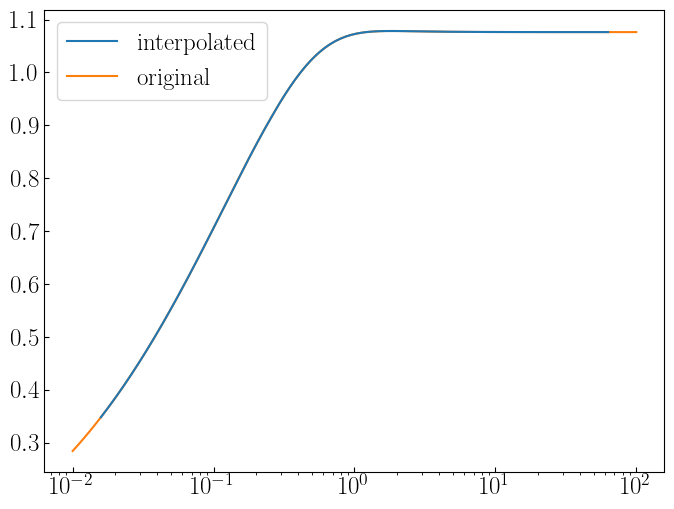

In [ ]:
nrows,ncols=1,1
py.figure(figsize=(8*ncols,6*nrows))
ax = py.subplot(nrows,ncols,1)

ax.plot(bTs_new,sud_mod,label=r'$\rm interpolated$',zorder=10)
ax.plot(bTs,sud0,label=r'$\rm original$')
ax.tick_params(direction='in',labelsize=18)
ax.semilogx()
ax.legend(fontsize=18)

In [ ]:
Q_new = torch.linspace(3,10,300,dtype=torch.float64)
bTs_new = 10**torch.linspace(-2,2,500,dtype=torch.float64)

In [ ]:
interpbT = interpolate(bTs,bTs_new,'cubic-turbo',device,torch.float64)
interpQ  = interpolate(Q,Q_new,'cubic-turbo',device,torch.float64)

In [ ]:
print(interpbT.shape,interpQ.shape,sud.shape)

torch.Size([500, 100]) torch.Size([300, 50]) torch.Size([100, 50])


In [ ]:
sud_new = torch.einsum('ib,bQ,jQ->ij',interpbT,sud,interpQ)

Text(0.4, 0.1, '$b_T=10.72~{\\rm GeV}^{-1}$')

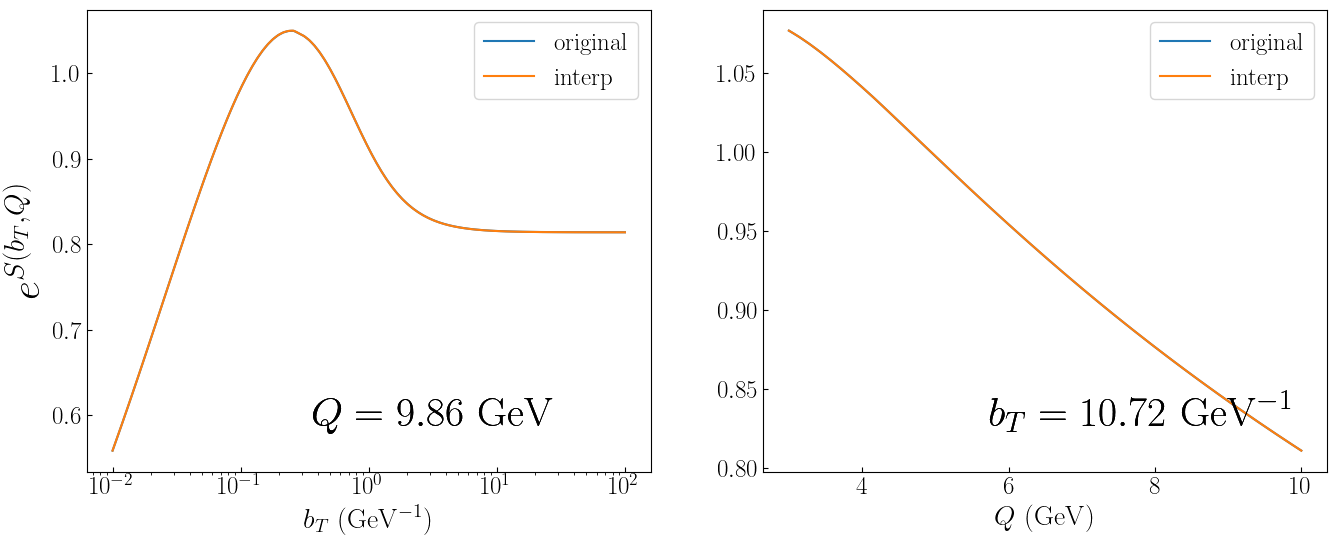

In [25]:
nrows,ncols=1,2
py.figure(figsize=(8*ncols,6*nrows))
ax = py.subplot(nrows,ncols,1)

# ax.plot(x_new[x_new>1],sud_mod[x_new>1],label=r'$\rm interpolated$')
# ax.plot(x_old[x_old>1],sud0[x_old>1],label=r'$\rm original$')

idx=-2
ax.plot(bTs,sud.T[idx],label=r'\rm original')
ax.text(0.4,0.1,r'$Q=%.2f~{\rm GeV}$'%Q[idx],transform=ax.transAxes,size=30)

idx = -7
ax.plot(bTs_new,sud_new.T[idx],label=r'$\rm interp$')
ax.tick_params(direction='in',labelsize=18)
ax.semilogx()
ax.legend(fontsize=18)
ax.set_xlabel(r'$b_T~({\rm GeV}^{-1})$',size=20)
ax.set_ylabel(r'$e^{S(b_T,Q)}$',size=30)
ax.text(0.4,0.1,r'$Q=%.2f~{\rm GeV}$'%Q_new[idx],transform=ax.transAxes,size=30)

ax=py.subplot(nrows,ncols,2)

idx=75
ax.plot(Q,sud[idx],label=r'$\rm original$')
ax.text(0.4,0.1,r'$b_T=%.2f~{\rm GeV}^{-1}$'%bTs[idx],transform=ax.transAxes,size=30)
idx=378
ax.plot(Q_new,sud_new[idx],label=r'$\rm interp$')
ax.tick_params(direction='in',labelsize=18)
ax.legend(fontsize=18)
ax.set_xlabel(r'$Q~({\rm GeV})$',size=20)
ax.text(0.4,0.1,r'$b_T=%.2f~{\rm GeV}^{-1}$'%bTs_new[idx],transform=ax.transAxes,size=30)


# Integration over $b_T$

## First take the Hankel transform of a known function
## $\int_0^\infty db_T b_T J_0(b_T q_T) K_0(n b_T) = \frac{1}{(n^2 + k_T^2)}$

In [29]:
def integrand(bT,qT):
    func = kv(0,2*bT)
    return bT * jv(0,bT * qT) * func
def integrand2(bT,qt):
    func = np.exp(0.01j*bT)/bT
    return bT*func*jv(0,bT*qt)

/home/joey/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


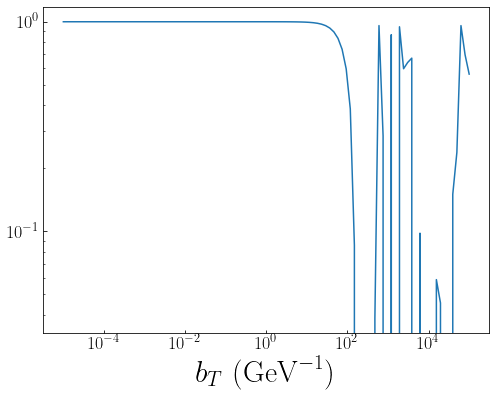

In [31]:
nrows,ncols = 1,1
py.figure(figsize=(8*ncols,6*nrows))

ax=py.subplot(nrows,ncols,1)

bTs = 10**np.linspace(-5,5,100)
qT = 0.0

intgd2 = integrand2(bTs,qT)
ax.plot(bTs,intgd2)
ax.semilogy()
ax.semilogx()
# ax.semilogy()
ax.set_xlabel(r'$b_T~({\rm GeV}^{-1})$',size=30)
ax.tick_params(direction='in',labelsize=18,which='both',axis='both')

In [24]:
def analytic_func(qT):
    return 1 / (4 + qT**2)
def analytic_func2(qT):
    return 1/np.sqrt(qT**2-0.01**2)

In [25]:
def get_WZ(bTnodes,pT,precision=1e-6):

    quad_precision = precision

    bTmax =100

    bTmin =1e-6
    if len(bTnodes)==0 or len(bTnodes)==1:
        W=quad(lambda bT: integrand2(bT,pT),bTmin,bTmax,epsrel=quad_precision)[0]
    else:
        flag='calculating'
        W=quad(lambda bT: integrand2(bT,pT),bTmin,bTnodes[1],epsrel=quad_precision)[0]
        if W==0:
            return 0.0
        for i in range(len(bTnodes)-1):
            #--i==even: negative integrand
            #--i==odd: positive integrand
            if i==0 or i==1: continue
            if flag=='finished': continue
            if i%2==0: continue
            intgrl=quad(lambda bT: integrand2(bT,pT),bTnodes[i-2],bTnodes[i],epsrel=quad_precision)[0]
            W+=intgrl
            if np.abs(intgrl/W) < precision: flag='finished'
        if flag!='finished':
            if len(bTnodes)%2==1:
                W+=quad(lambda bT: integrand2(bT,pT),bTnodes[-2],bTmax,epsrel=quad_precision)[0]
            else:
                W+=quad(lambda bT: integrand2(bT,pT),bTnodes[-1],bTmax,epsrel=quad_precision)[0]

    return W

In [26]:
largest_nodes=jn_zeros(0,1000)

qTs = np.linspace(1e-3,10,100)
bmax = 100

numeric=[]
for qt in qTs:
    bTnodes = largest_nodes[largest_nodes/(qt) < bmax]/(qt)
    numeric.append(get_WZ(bTnodes,qt,1e-20))
numeric=np.array(numeric)

analytic = analytic_func2(qTs)
print(analytic)

[       nan 9.85138008 4.93209626 3.29125484 2.46988882 1.97667064
 1.64767007 1.41257029 1.23618839 1.09896746 0.98916807 0.89931694
 0.82443032 0.76105705 0.70673143 0.65964496 0.61844102 0.58208204
 0.54976092 0.5208404  0.49481061 0.47125877 0.44984711 0.43029658
 0.41237464 0.39588592 0.38066511 0.36657138 0.353484   0.34129892
 0.32992591 0.31928643 0.30931172 0.29994136 0.29112205 0.28280656
 0.27495292 0.2675237  0.26048538 0.25380792 0.24746426 0.24142996
 0.23568295 0.23020319 0.22497245 0.21997414 0.2151931  0.21061546
 0.20622853 0.20202061 0.19798099 0.19409974 0.19036775 0.18677657
 0.18331836 0.17998589 0.17677242 0.17367168 0.17067784 0.16778547
 0.1649895  0.16228519 0.15966809 0.15713407 0.15467923 0.1522999
 0.14999267 0.1477543  0.14558175 0.14347217 0.14142285 0.13943126
 0.13749497 0.13561173 0.13377938 0.13199589 0.13025933 0.12856786
 0.12691976 0.12531338 0.12374716 0.1222196  0.12072929 0.11927489
 0.11785512 0.11646875 0.11511462 0.11379161 0.11249866 0.11123

/tmp/ipykernel_28376/4276074570.py:4: RuntimeWarning: invalid value encountered in sqrt
  return 1/np.sqrt(qT**2-0.01**2)


In [27]:
rel_err = (numeric - analytic) / analytic

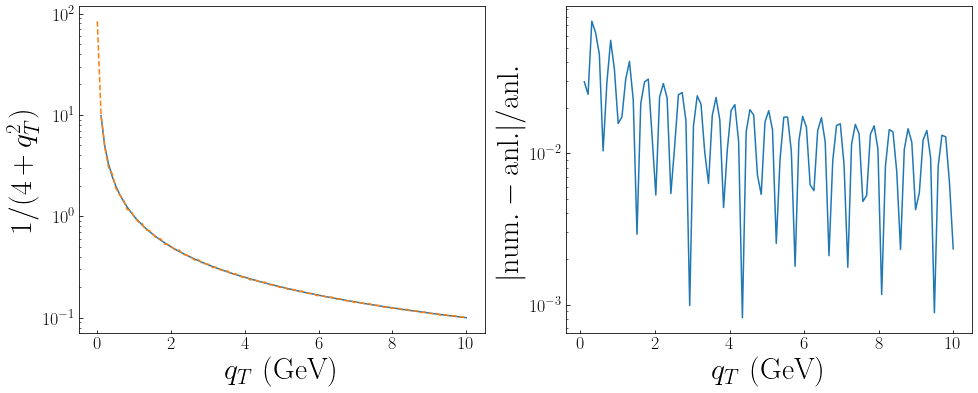

In [28]:
nrows,ncols=1,2
py.figure(figsize=(8*ncols,6*nrows))

ax=py.subplot(nrows,ncols,1)
ax.plot(qTs,analytic,label=r'$\rm analytic$')
ax.plot(qTs,numeric,'--',label=r'$\rm numeric$')
ax.set_xlabel(r'$q_T~({\rm GeV})$',size=30)
ax.set_ylabel(r'$1/(4 + q_T^2)$',size=30)
ax.tick_params(direction='in',labelsize=18,which='both',axis='both')
ax.semilogy()

ax=py.subplot(nrows,ncols,2)
ax.plot(qTs,np.abs(rel_err))
ax.set_xlabel(r'$q_T~({\rm GeV})$',size=30)
ax.set_ylabel(r'$\rm |num. - anl.|/anl.$',size=30)
ax.semilogy()
ax.tick_params(direction='in',labelsize=18,which='both',axis='both')

In [124]:
from scipy import fft
mu = 0.0                     # Order mu of Bessel function
b = np.logspace(-7, 1, 128*4)  # Input evaluation points
dln = np.log(b[1]/b[0])      # Step size
offset = fft.fhtoffset(dln, initial=-6*np.log(10), mu=mu)
qTs = np.exp(offset)/b[::-1]   # Output evaluation points

In [125]:
def ac(bT,n):
    return bT * kv(0,n*bT)

In [126]:
a_c = ac(b, 2)
fht = fft.fht(a_c, dln, mu=mu, offset=offset)

In [131]:
At = fht / qTs

In [132]:
largest_nodes=jn_zeros(0,1000)

#qTs = np.linspace(1e-3,10,100)
bmax = 100

numeric=[]
for qt in qTs:
    bTnodes = largest_nodes[largest_nodes/(qt) < bmax]/(qt)
    numeric.append(get_WZ(bTnodes,qt,1e-20))
numeric=np.array(numeric)

analytic = analytic_func(qTs)

In [133]:
rel_err_quad = (numeric - analytic) / analytic
rel_err_fht = (At - analytic) / analytic

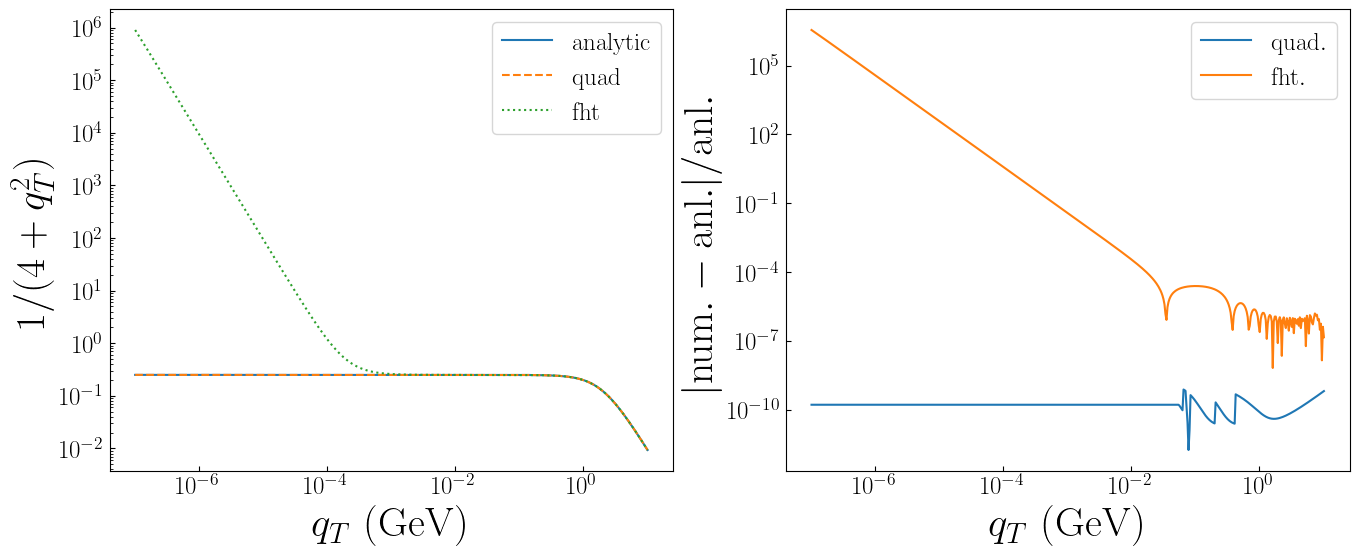

In [134]:
nrows,ncols=1,2
py.figure(figsize=(8*ncols,6*nrows))

ax=py.subplot(nrows,ncols,1)
ax.plot(qTs,analytic,label=r'$\rm analytic$')
ax.plot(qTs,numeric,'--',label=r'$\rm quad$')
ax.plot(qTs,At,':',label=r'$\rm fht$')
ax.set_xlabel(r'$q_T~({\rm GeV})$',size=30)
ax.set_ylabel(r'$1/(4 + q_T^2)$',size=30)
ax.tick_params(direction='in',labelsize=18,which='both',axis='both')
ax.semilogy()
ax.semilogx()
ax.legend(fontsize=18)

ax=py.subplot(nrows,ncols,2)
ax.plot(qTs,np.abs(rel_err_quad),label=r'$\rm quad.$')
ax.plot(qTs,np.abs(rel_err_fht),label=r'$\rm fht.$')
ax.set_xlabel(r'$q_T~({\rm GeV})$',size=30)
ax.set_ylabel(r'$\rm |num. - anl.|/anl.$',size=30)
ax.semilogy()
ax.semilogx()
ax.tick_params(direction='in',labelsize=18,which='both',axis='both')
ax.legend(fontsize=18)

## Try with the TMDs
## $\int_0^\infty db_T b_T J_0(b_T q_T) \tilde{f}(x,Q,b_T) = f(x,Q,k_T)$

In [33]:
def integrand(bT,x,Q,qT):
    # func = kv(0,2*bT)
    fNP = np.exp(-0.2 * bT**2)

    #--up quark
    func = ope.get_OPE_TMDPDF(x,bT)[1] * pertevo.get_exp_Sudakov_perturbative(Q,bT) * fNP
    
    return bT * jv(0,bT * qT) * func

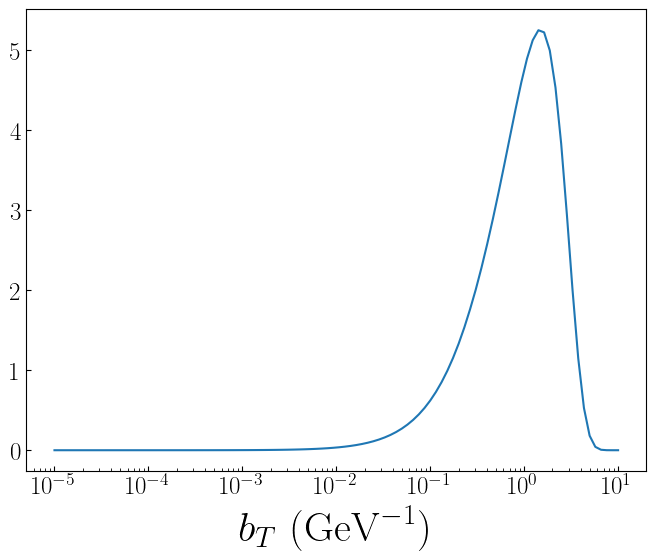

In [34]:
nrows,ncols = 1,1
py.figure(figsize=(8*ncols,6*nrows))

ax=py.subplot(nrows,ncols,1)

bTs = 10**np.linspace(-5,1,100)
x = 0.1
Q = 10
qT = 0.0

intgd = np.array([integrand(_,x,Q,qT) for _ in bTs])
ax.plot(bTs,intgd)
ax.semilogx()
# ax.semilogy()
ax.set_xlabel(r'$b_T~({\rm GeV}^{-1})$',size=30)
ax.tick_params(direction='in',labelsize=18,which='both',axis='both')

In [35]:
def get_WZ(bTnodes,x,Q,pT,precision=1e-6):

    quad_precision = precision

    bTmax =10

    bTmin =1e-6
    if len(bTnodes)==0 or len(bTnodes)==1:
        W=quad(lambda bT: integrand(bT,x,Q,pT),bTmin,bTmax,epsrel=quad_precision)[0]
    else:
        flag='calculating'
        W=quad(lambda bT: integrand(bT,x,Q,pT),bTmin,bTnodes[1],epsrel=quad_precision)[0]
        if W==0:
            return 0.0
        for i in range(len(bTnodes)-1):
            #--i==even: negative integrand
            #--i==odd: positive integrand
            if i==0 or i==1: continue
            if flag=='finished': continue
            if i%2==0: continue
            intgrl=quad(lambda bT: integrand(bT,x,Q,pT),bTnodes[i-2],bTnodes[i],epsrel=quad_precision)[0]
            W+=intgrl
            if np.abs(intgrl/W) < precision: flag='finished'
        if flag!='finished':
            if len(bTnodes)%2==1:
                W+=quad(lambda bT: integrand(bT,x,Q,pT),bTnodes[-2],bTmax,epsrel=quad_precision)[0]
            else:
                W+=quad(lambda bT: integrand(bT,x,Q,pT),bTnodes[-1],bTmax,epsrel=quad_precision)[0]

    return W

In [ ]:
largest_nodes=jn_zeros(0,1000)

qTs = np.linspace(1e-3,10,50)
bmax = 10
x = 0.1
Q = 100
numeric=[]
for i in range(len(qTs)):
    # print(i)
    qt = qTs[i]
    bTnodes = largest_nodes[largest_nodes/(qt) < bmax]/(qt)
    numeric.append(get_WZ(bTnodes,x,Q,qt,1e-20))
numeric=np.array(numeric)

/scratch/slurm/34112562/.cache/tmp/ipykernel_3300615/1130984758.py:9: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  W=quad(lambda bT: integrand(bT,x,Q,pT),bTmin,bTmax,epsrel=quad_precision)[0]
/scratch/slurm/34112562/.cache/tmp/ipykernel_3300615/1130984758.py:12: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain

In [ ]:
# rel_err = (numeric - analytic) / analytic

In [ ]:
nrows,ncols=1,2
py.figure(figsize=(8*ncols,6*nrows))

ax=py.subplot(nrows,ncols,1)
# ax.plot(qTs,analytic,label=r'$\rm analytic$')
ax.plot(qTs,np.abs(numeric),'--',label=r'$\rm numeric$')
ax.set_xlabel(r'$q_T~({\rm GeV})$',size=30)
# ax.set_ylabel(r'$1/(4 + q_T^2)$',size=30)
ax.tick_params(direction='in',labelsize=18,which='both',axis='both')
ax.semilogy()

# ax=py.subplot(nrows,ncols,2)
# ax.plot(qTs,np.abs(rel_err))
# ax.set_xlabel(r'$q_T~({\rm GeV})$',size=30)
# ax.set_ylabel(r'$\rm |num. - anl.|/anl.$',size=30)
# ax.semilogy()
# ax.tick_params(direction='in',labelsize=18,which='both',axis='both')